In [1]:
! pip install torchopt

In [380]:
import torch
import torch.nn as nn
from functorch import make_functional, grad, vmap, vjp, jacrev, jacfwd
import torchopt
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [381]:
##define the customized step function using torchopt's framework
##it does not retain or create the computational graph, using much less memory

from torchopt.update import apply_updates
from torchopt.typing import UninitializedState

def costum_step(
        optimizer,
        loss: torch.Tensor,
        params,
        inplace: bool | None = None,
        decay = False,
        gamma = 1,
        every = 100,
        num_iter = None
    ):
        if isinstance(optimizer.optim_state, UninitializedState):
            optimizer.optim_state = optimizer.impl.init(params)

        if inplace is None:
            inplace = optimizer.inplace

        # Step parameter only
        grads = torch.autograd.grad(loss, params, create_graph=False, retain_graph=False, allow_unused=True)
        if decay:
          grads = tuple(grads[i]*(gamma**(num_iter/every)) for i in range(len(grads)))
        updates, optimizer.optim_state = optimizer.impl.update(
            grads,
            optimizer.optim_state,
            params=params,
            inplace=inplace,
        )
        return apply_updates(params, updates, inplace=inplace)

### One Shot Transfer Learning for Van der Pols Oscillator
$$
\begin{align*}
\frac{dx}{dt} &= y ,\quad \frac{dy}{dt} &= \alpha(1 - x^2)y - x
\end{align*}
$$
with initial conditions $x_0=2$ and $y_0=0$ and $\alpha>1$ the stiffness parameter.

After rescaling $\tilde{x} = \frac{x}{\lambda}$ and $\tilde{y} = \frac{y}{\lambda}$ with $0<\lambda<1$
$$
\begin{align*}
\frac{d\tilde{x}}{dt} &= \tilde{y} ,\quad \frac{d\tilde{y}}{dt} &= \alpha(1 - \lambda^2\tilde{x}^2)\tilde{y} - \tilde{x} = \alpha\tilde{y} - \tilde{x} - \alpha\lambda^2\tilde{x}^2\tilde{y}
\end{align*}
$$
with initial conditions $x_0= \frac{2}{\lambda}$ and $y_0=\frac{0}{\lambda}=0$

Then by $\lambda$-perturbation expansion $\tilde{x}=\sum_{i=0}^{\infty}\lambda^iX_i$ and $\tilde{y}=\sum_{i=0}^{\infty}\lambda^iY_i$ with have these systems for the various power of $\lambda^i$ with $i=0, 1, 2, ...$
$$
\begin{align*}
\frac{dX_i}{dt} - Y_i &= 0, \quad \frac{dY_i}{dt} - \alpha Y_i + X_i &= f_i \\
\end{align*} \\
\begin{align*}
f_i = \begin{cases}
0 \ \text{for} \ i \in \{0, 1\} \\
-\alpha\sum_{a+b+c=i-2}^{0<a,b,c<p}\phi(a,b,c)x_ax_by_c \ \ \text{with} \ \phi(a,b,c)=\begin{cases}
1 \ \text{if} \ a=b \\
2 \ \text{otherwise}
\end{cases}
\end{cases}
\end{align*}
$$

So these are linear system with A = $
\begin{bmatrix}
  0 & -1 \\
  1 & -\alpha 
\end{bmatrix}
$ and f = $\begin{bmatrix}
  0 \\
  f_i 
\end{bmatrix}$


### Solve the Linear System after perturbation approach with force function = [0, 0]

In [382]:
class Multihead(nn.Module):
  def __init__(self, k, act = nn.Tanh()):
    super().__init__()
    self.act = act
    self.linear1 = nn.Linear(1, 256)
    self.linear2 = nn.Linear(256, 256)
    self.linear3 = nn.Linear(256, 256)
    self.linear4 = nn.Linear(256, 512)
    ##define k final layers without bias
    self.final_layers = nn.ModuleList(
        ##use 257 if include the bias
        [nn.Linear(256, 1, bias=False) for _ in range(k)]
    )
    self.k = k

  #it returns the output of the network and the hidden state
  def forward(self, x):
    out = self.act(self.linear1(x))
    out = self.act(self.linear2(out))
    out = self.act(self.linear3(out))
    out = self.act(self.linear4(out))
    out1 = out[:256]
    #out1 = torch.cat((torch.Tensor([1]), out1))
    out2 = out[256:]
    #out2 = torch.cat((torch.Tensor([1]), out2))
    output = []
    for i in range(self.k):
      first = self.final_layers[i](out1)
      second = self.final_layers[i](out2)
      concat = torch.cat((first, second))
      output.append(concat)
    return torch.stack(output), out

In [383]:
##construct a model of 10 heads
k=10
model = Multihead(k=k)
fmodel, params = make_functional(model)

d:\Logiciel\Anaconda\envs\pinns\lib\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


In [486]:
##make the model fully functional and define the jacobian function
##this function only returns the output of the network
def f_multihead(x, params):
  x_ = x.unsqueeze(0)
  res = fmodel(params, x_)[0].squeeze(0)
  return res

#if input x contains B elements
##the output of this function will be a tensor of shape (B, k, 2)
##where k is the number of heads
f_multihead_vmap = vmap(f_multihead, in_dims=(0, None), randomness="same")

##define gradient of the NN
dfdx_multihead = vmap(jacfwd(f_multihead), in_dims=(0, None), randomness="same")

##this function returns the hidden state of the network
##the hidden state depends on: 1. time 2. parameters of the network
def hidden_state(x, params):
  x_ = x.unsqueeze(0)
  H = fmodel(params, x_)[1].squeeze(0)
  return H

##returns the batched hidden states of shape (B, 512)
hidden_state_vmap = vmap(hidden_state, in_dims=(0, None), randomness="same")

#define gradient of the hidden state H'
#returns the batched gradients of the hidden states of shape (B, 512)
dHdx = vmap(jacrev(hidden_state), in_dims=(0, None), randomness="same")

d:\Logiciel\Anaconda\envs\pinns\lib\site-packages\torch\_functorch\deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
d:\Logiciel\Anaconda\envs\pinns\lib\site-packages\torch\_functorch\deprecated.py:85: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacfwd')
d:\Logiciel\A

In [385]:
alpha_bounds = (1, 3)
boundary_bounds = (-3, 3)
v0_bounds = (-1, 1)

##this function generates k sets of parameters
##it returns a numpy array of shape (k, 4)
##and another numpy array of shape(k,) <- boundary values
def generate_parameters(k, ab = alpha_bounds, seed=10):
  parameters = np.zeros((k, 2))
  boundaries = np.zeros(k)
  velocities = np.zeros(k)
  ##set the random seed
  np.random.seed(seed)
  for i in range(k):
    parameters[i] = [1.,
                     np.random.uniform(ab[0], ab[1])]
    boundaries[i] = 2.
    velocities[i] = 0.
  return parameters, boundaries, velocities

In [386]:
##generate the parameter set
parameter_set, F_BOUNDARIES, V0 = generate_parameters(k)

In [387]:
##decorator to return a forcing function of form gamma*cos(w*t)
##the returned function returns a vector of [initial_velocity(v0), f]
def force_decorator():
  def force(x):
    return torch.stack([torch.zeros_like(x), torch.zeros_like(x)]).T
    #return torch.stack([torch.zeros_like(x), gamma*np.cos(w*x)]).T
  return force

##construct a list forcing function from the parameter set
forcing_functions = [force_decorator() for p in parameter_set]
##construct a tensor that stores k matrice A (10, 2, 2) from the parameter set
A_matrices = torch.zeros(k, 2, 2)
for i in range(k):
  A_matrices[i] = torch.Tensor([[0.0, -1.0], [parameter_set[i][0], -parameter_set[i][1]]])

##boundary condition
X_BOUNDARY = 0.0

In [388]:
A_matrices

tensor([[[ 0.0000, -1.0000],
         [ 1.0000, -2.5426]],

        [[ 0.0000, -1.0000],
         [ 1.0000, -1.0415]],

        [[ 0.0000, -1.0000],
         [ 1.0000, -2.2673]],

        [[ 0.0000, -1.0000],
         [ 1.0000, -2.4976]],

        [[ 0.0000, -1.0000],
         [ 1.0000, -1.9970]],

        [[ 0.0000, -1.0000],
         [ 1.0000, -1.4496]],

        [[ 0.0000, -1.0000],
         [ 1.0000, -1.3961]],

        [[ 0.0000, -1.0000],
         [ 1.0000, -2.5211]],

        [[ 0.0000, -1.0000],
         [ 1.0000, -1.3382]],

        [[ 0.0000, -1.0000],
         [ 1.0000, -1.1767]]])

In [389]:
##define the loss function
##F_BOUNDARIES is an array of length k, containing the initial values of k ODEs
##V0 is an array of length k, containing the initial velocities of k ODEs
def loss_fn(params, x, A_matrices, F_BOUNDARIES, V0,
            forcing_functions, alpha=1, X_BOUNDARY=0.0):
  #interior loss
  f_values = f_multihead_vmap(x, params) ##of shape (30, 10, 2)
  f_gradients = dfdx_multihead(x, params) ##of shape (30, 10, 2)
  # Expand dimensions of 'A_matrices' to match the shape of 'f_values'
  expanded_A_matrices = A_matrices.unsqueeze(0).expand(f_values.shape[0], -1, -1, -1)
  # Perform element-wise matrix multiplication using broadcasting
  Au = torch.matmul(expanded_A_matrices, f_values.unsqueeze(-1)).squeeze(-1)
  del expanded_A_matrices

  forcing = torch.stack([f(x) for f in forcing_functions]).transpose(1, 0) #shape (30, 10, 2)
  interior = f_gradients + Au - forcing #of shape (30, 10, 2)
  del f_gradients, Au, forcing

  x_boundary = torch.tensor([X_BOUNDARY])
  f_boundary = torch.stack([torch.Tensor([b, V0[i]]) for i,b in enumerate(F_BOUNDARIES)])
  boundary = f_multihead_vmap(x_boundary, params) - f_boundary ##of shape (1, 10, 2)

  loss = nn.MSELoss()
  loss_colocation = loss(interior, torch.zeros_like(interior))
  loss_BC = loss(boundary, torch.zeros_like(boundary))
  loss_value = alpha*loss_colocation + (2-alpha)*loss_BC

  return loss_value, loss_colocation, loss_BC

In [390]:
#define optimization configuration
batch_size = 200 ##number of colocation points sampled in each iteration
num_iter = 5000 #maximum number of iterations
learning_rate = 2e-4
domain = (0, 1.0) #logistic equation domain

'''
======= training hyper-parameters for 10 head ODE with 0 initial velocities
batch_size = 100 ##number of colocation points sampled in each iteration
num_iter = 3000 #maximum number of iterations
learning_rate = 3e-4
domain = (0, 5.0) #logistic equation domain
'''

#choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

##define the function that trains the model
def train_model(num_iter, params, batch_size, domain, A_matrices,
                F_BOUNDARIES, V0,
                forcing_functions,optimizer, alpha=1, display_every=10,
                decay=False, gamma = 1, every = 100):
  loss_trace = []; colocation_trace = []; BC_trace = []

  for i in range(num_iter):

    # sample colocation points in the domain randomly at each iteration
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    #update the parameters using the functional API
    loss, loss_colocation, loss_BC = loss_fn(params, x, A_matrices, F_BOUNDARIES, V0,
                                             forcing_functions, alpha=alpha)
    params = costum_step(optimizer, loss, params, decay=decay, gamma=gamma, every=every, num_iter=i+1)
    loss_trace.append(float(loss))
    colocation_trace.append(float(loss_colocation))
    BC_trace.append(float(loss_BC))

    if ((i+1)%display_every == 0):
      print(f"Iteration {i} with loss {float(loss)}, colocation: {float(loss_colocation)}, BC: {float(loss_BC)}")

    del loss, loss_colocation, loss_BC
  return params, loss_trace, colocation_trace, BC_trace

In [391]:
Alpha=1
new_params, loss_trace, colocation_trace, BC_trace = train_model(num_iter, params,
                          batch_size, domain, A_matrices, F_BOUNDARIES, V0,
                  forcing_functions, optimizer, alpha=Alpha, display_every=100,
                          decay=True, gamma = 0.96, every = 100)

Iteration 99 with loss 0.1405925452709198, colocation: 0.04194582998752594, BC: 0.09864671528339386
Iteration 199 with loss 0.06627538055181503, colocation: 0.015140684321522713, BC: 0.05113469436764717
Iteration 299 with loss 0.03382304310798645, colocation: 0.009775223210453987, BC: 0.024047821760177612
Iteration 399 with loss 0.01642826944589615, colocation: 0.00576355354860425, BC: 0.010664715431630611
Iteration 499 with loss 0.009270626120269299, colocation: 0.004493701737374067, BC: 0.004776924382895231
Iteration 599 with loss 0.008541679009795189, colocation: 0.004352928139269352, BC: 0.004188750870525837
Iteration 699 with loss 0.0023066094145178795, colocation: 0.0007239578990265727, BC: 0.001582651399075985
Iteration 799 with loss 0.0013255064841359854, colocation: 0.00048822053940966725, BC: 0.000837286002933979
Iteration 899 with loss 0.000926496519241482, colocation: 0.0006670962320640683, BC: 0.0002594002871774137
Iteration 999 with loss 0.0006780981784686446, colocation:

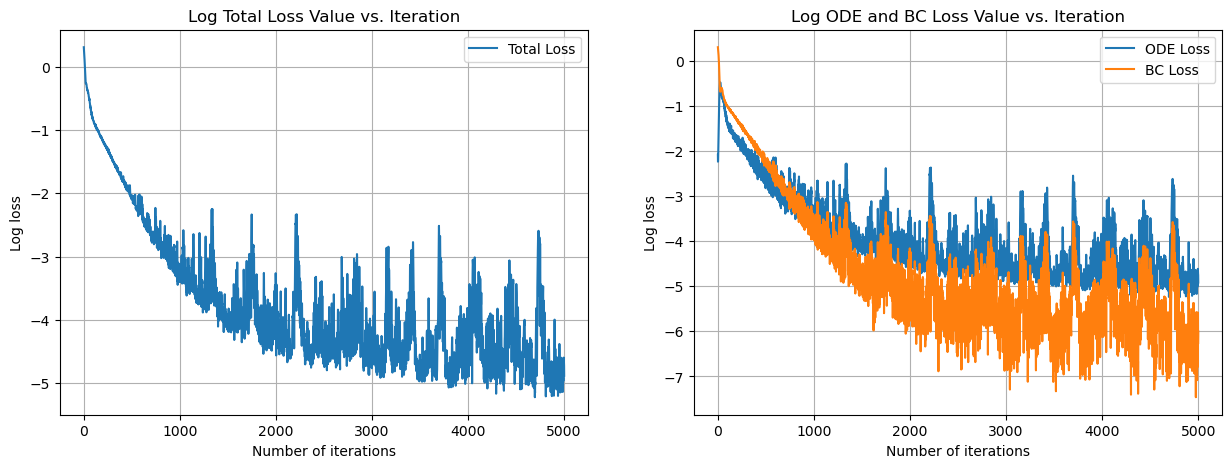

In [392]:
##plot the loss value
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(range(1, num_iter+1), np.log10(loss_trace), label='Total Loss');
ax[1].plot(range(1, num_iter+1), np.log10(colocation_trace), label='ODE Loss');
ax[1].plot(range(1, num_iter+1), np.log10(BC_trace), label="BC Loss");

ax[0].set_xlabel("Number of iterations");
ax[0].set_ylabel("Log loss");
ax[0].set_title("Log Total Loss Value vs. Iteration");
ax[0].grid();
ax[0].legend();
ax[1].set_xlabel("Number of iterations");
ax[1].set_ylabel("Log loss");
ax[1].set_title("Log ODE and BC Loss Value vs. Iteration");
ax[1].grid();
ax[1].legend();

In [488]:
#get the network solution
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.05))
Y_NN = f_multihead_vmap(X_grid, new_params) #shape (100, 10, 2)
Y_NN = Y_NN.transpose(0, 1)

In [394]:
##get numerical solutions
#define the RHS function decorator
def RHS_decorator(alpha):
  def func(t, y):
    y = np.array(y)
    A_mat = np.array([[0, -1], [1, -alpha]])
    return -A_mat@y + np.array([0, 0])
  return func

k=10

t_eval = np.arange(domain[0], domain[1], 0.05)
##construct a list of RHS functions
RHS_functions = [RHS_decorator(p[1]) for p in parameter_set]

numerical_result = [solve_ivp(RHS_functions[i], domain,
                    np.array([F_BOUNDARIES[i], V0[i]]), t_eval=t_eval, method = 'DOP853') for i in range(k)]

### Plot the Network Solution together with the Numerical Solution

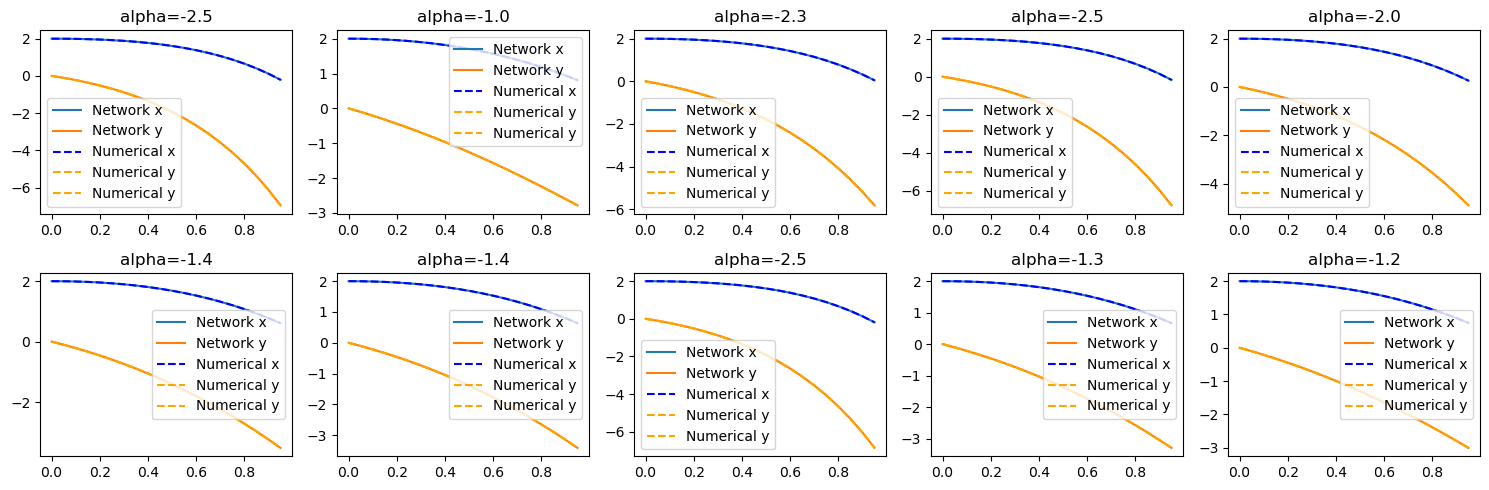

In [395]:
fig, ax = plt.subplots(2, 5, figsize=(15, 5));
for i in range(10):
  j = i//5; l = i%5
  ax[j][l].plot(X_grid, Y_NN[i][:,0].detach().numpy(), label="Network x");
  ax[j][l].plot(X_grid, Y_NN[i][:,1].detach().numpy(), label='Network y');
  ax[j][l].plot(t_eval, numerical_result[i].y[0], '--', c='blue',label='Numerical x');
  ax[j][l].plot(t_eval, numerical_result[i].y[1], '--', c='orange',label='Numerical y');
  ax[j][l].plot(t_eval, numerical_result[i].y[1], '--', c='orange',label='Numerical y');
  ax[j][l].set_title(f"alpha={A_matrices[i][1, 1]:.1f}")
  ax[j][l].legend();
fig.tight_layout()

## One-Shot Transfer Learning

In [518]:
##this function returns the matrix M
##x is the batch of time (Tensor)
##params is the parameters of the neural network
##alpha is the parameter used in the ODE
##Alpha is the weight used in the loss function
def M_matrix(x, alpha, params, Alpha=1):
  ##compute the batched Hidden states
  Hs = hidden_state_vmap(x, params).detach().numpy() #(B, 512)
  ##compute the batched gradients of the hidden states
  H_primes = dHdx(x, params).detach().numpy() #(B, 512)
  ##construct the matrix A
  A = np.array([[0.0, -1.0], [1, -alpha]])

  #compute the first part of the matrix M
  results = []
  for i in range(Hs.shape[0]):
    h = Hs[i].reshape(2, 256)
    #h = np.hstack((np.ones((h.shape[0], 1)), h)) ##add the bias column
    hp = H_primes[i].reshape(2, 256)
    #hp = np.hstack((np.zeros((hp.shape[0], 1)), hp)) ##add the bias column
    B = hp.T@A@h
    matrix = hp.T@hp + B + B.T + h.T@A.T@A@h
    results.append(matrix)
  results = np.array(results)
  results = np.mean(results, axis=0)

  #compute the second part of the matrix M
  #compute the hidden state at time 0
  h0 = hidden_state_vmap(torch.Tensor([0]), params).detach().numpy()[0].reshape(2, 256)
  #h0 = np.hstack((np.ones((h0.shape[0], 1)), h0)) ##add the bias column
  return Alpha*results + (2-Alpha)*h0.T@h0

#compute the analytic W that minimizes the loss function
#alpha is the parameter used in the ODE
#Alpha is the weight used in the loss functioon
##v0 is the initial verlocity of the system
def compute_W(x, alpha, params, Minv, F, boundary_value, v0=0, Alpha=1):
  h0 = hidden_state_vmap(torch.Tensor([0]), params).detach().numpy()[0].reshape(2, 256)
  #h0 = np.hstack((np.ones((h0.shape[0], 1)), h0)) ##add the bias column
  u0 = np.array([[boundary_value], [v0]]) ##boundary condition

  ##compute the batched Hidden states
  Hs = hidden_state_vmap(x, params).detach().numpy()
  ##compute the batched gradients of the hidden states
  H_primes = dHdx(x, params).detach().numpy()
  ##construct the matrix A
  A = np.array([[0.0, -1.0], [1, -alpha]])

  fs = F(x) #(B, 2) shape
  if type(fs) is not np.ndarray:
    fs = fs.numpy()
  results = []
  for i in range(Hs.shape[0]):
    h = Hs[i].reshape(2, 256)
    #h = np.hstack((np.ones((h.shape[0], 1)), h)) ##add the bias column
    hp = H_primes[i].reshape(2, 256)
    #hp = np.hstack((np.zeros((hp.shape[0], 1)), hp)) ##add the bias column
    f = fs[i].reshape(2, 1)
    results.append((hp.T + h.T@A.T)@f)
  results = np.array(results)
  results = Alpha*np.mean(results, axis=0) + (2-Alpha)*h0.T@u0
  W = Minv@results
  return W

In [519]:
##get the true numerical solution
#define the RHS function
def RHS_decorator(alpha):
  def func(t, y):
    y = np.array(y)
    A_mat = np.array([[0, -1], [1, -alpha]])
    return -A_mat@y + np.array([0, 0])
  return func

#this function gives you the solution of an unseen ODE using one-shot transfer learning
#x: tensor: batched tensors of inputs to compute the M and W
#a, d, r, omega, boundary are all parameters of the ODE
#params: is the trained network's parameters
#X_grid: the values at which we want to evaluate the network at
#returns:
#a numpy nd array of (N, 2) where N is the size of X_grid
def one_shot_TL(x, alpha, boundary, params, X_grid, Alpha=1, v0=0, F = None):
  ##decorator to return a forcing function of form gamma*cos(w*t)
  def force_decorator():
    def force(x):
      return torch.stack([torch.zeros_like(x), torch.zeros_like(x)]).T
    return force
  M = M_matrix(x, alpha, params, Alpha=Alpha); Minv = np.linalg.pinv(M)
  #define forcing function
  if F is None:
    F = force_decorator()
  ##compute the analytic W
  W = compute_W(x, alpha, params, Minv, F, boundary, v0=v0, Alpha=Alpha)
  Hs = hidden_state_vmap(X_grid, params).detach().numpy()
  analytic_result = []
  for i in range(X_grid.shape[0]):
    h = Hs[i].reshape(2, 256)
    #h = np.hstack((np.ones((h.shape[0], 1)), h)) ##add the bias column
    analytic_result.append(h@W)
  analytic_result = np.array(analytic_result)
  return analytic_result, W

##this function computes the numerical solution on X_grid values
def compute_numerical_solution(alpha, boundary, X_grid, domain, v0=0):
  numerical_solution = solve_ivp(RHS_decorator(alpha), domain, np.array([boundary, v0]),
                             t_eval=X_grid, method='DOP853')
  return numerical_solution

Try out the following unseen parameter
$
\alpha = 5,
$

In [520]:
##get the network solution for this parameter set
alpha_transfer = 3; boundary = 2; Alpha=1
x = torch.FloatTensor(100).uniform_(domain[0], domain[1])
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.05))
analytic_result, W = one_shot_TL(x, alpha_transfer, boundary, new_params, X_grid, Alpha=Alpha)
##get the numerical solution
numerical_solution = compute_numerical_solution(alpha_transfer, boundary, X_grid, domain)

In [521]:
hidden_state_vmap(X_grid, params).detach().numpy()[0].reshape(2, 256)@W

array([[-6.42450418],
       [-0.75324924]])

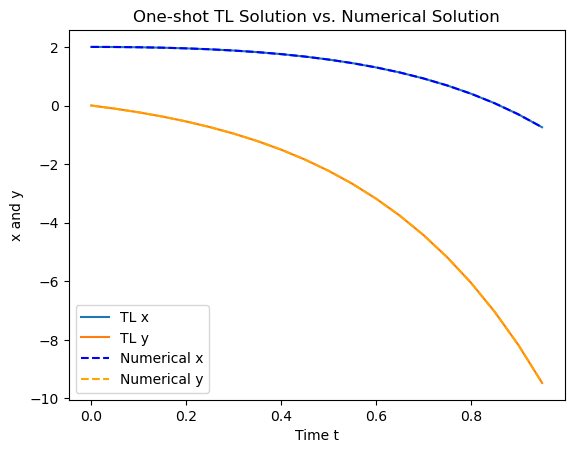

In [522]:
plt.plot(X_grid, analytic_result[:,0], label='TL x');
plt.plot(X_grid, analytic_result[:,1], label='TL y')
plt.plot(X_grid, numerical_solution.y[0], '--', c='blue', label="Numerical x");
plt.plot(X_grid, numerical_solution.y[1], '--', c='orange', label="Numerical y");
plt.legend();
plt.xlabel("Time t");
plt.ylabel("x and y");
plt.title("One-shot TL Solution vs. Numerical Solution");

Now we need to find a way to quantatively measure the transfer-learning results. We will define the previous loss function for the TL learnt network.

In [523]:
##this function computes the loss of the PINN after one-shot TL
def loss_TL(x, params, alpha, W, boundary, Alpha=1, v0=0, F = None):
  H_prime = dHdx(x, params).detach().numpy() #B by 512
  H = hidden_state_vmap(x, params).detach().numpy() #B by 512
  A = np.array([[0.0, -1.0], [1, -alpha]])
  if F is None:
    F = force_decorator()
  fs = F(x)
  if type(fs) is not np.ndarray:
    fs = F(x).numpy()
  #colocation loss
  colo = []
  for i in range(H.shape[0]):
    hp = H_prime[i].reshape(2, 256)
    #hp = np.hstack((np.zeros((hp.shape[0], 1)), hp)) ##add the bias column
    h = H[i].reshape(2, 256)
    #h = np.hstack((np.ones((h.shape[0], 1)), h)) ##add the bias column
    colo.append((hp+A@h)@W - fs[i].reshape(2, 1))
  colo = np.array(colo)
  loss_colocation = (colo**2).sum()/H.shape[0]
  ##BC loss
  H0 = hidden_state_vmap(torch.Tensor([0]), params).detach().numpy()[0].reshape(2, 256)
  #H0 = np.hstack((np.ones((H0.shape[0], 1)), H0)) ##add the bias column
  u0 = H0@W
  loss_BC = ((u0 - np.array([[boundary], [v0]]))**2).sum()
  return alpha*loss_colocation + (2-alpha)*loss_BC, loss_colocation, loss_BC

In [524]:
Alpha = 1
total_loss, loss_colo, loss_BC = loss_TL(x, new_params, alpha_transfer, W, boundary, Alpha=Alpha)
print("Using alpha = {}, the loss statistics of the previous parameter set is:".format(Alpha))
print("Weighted Total Loss: {}".format(total_loss))
print("Colocation Loss: {}".format(loss_colo))
print("BC loss: {}".format(loss_BC))

Using alpha = 1, the loss statistics of the previous parameter set is:
Weighted Total Loss: 1.4514525057586872e-06
Colocation Loss: 4.838175223586931e-07
BC loss: 6.131739209024544e-14


### Try another 10 in-distribution parameter sets
First with 0 initial velocities.

In [417]:
##generate the parameter set
k = 10
new_parameters, NEW_BOUNDARIES, _ = generate_parameters(k, seed=108)

In [418]:
new_solutions_TL = []
new_solutions_numerical = []
TL_Losses = [];
import time
s = time.time()
for i in range(k):
  _, alpha = new_parameters[i]
  analytic, W = one_shot_TL(x, alpha, NEW_BOUNDARIES[i], new_params, X_grid)
  numerical = compute_numerical_solution(alpha, NEW_BOUNDARIES[i], X_grid, domain)
  TL_Losses.append(loss_TL(x, new_params, alpha, W, NEW_BOUNDARIES[i], Alpha=Alpha))
  new_solutions_TL.append(analytic)
  new_solutions_numerical.append(numerical)
e = time.time()
print((e-s)/k)

1.3664753198623658


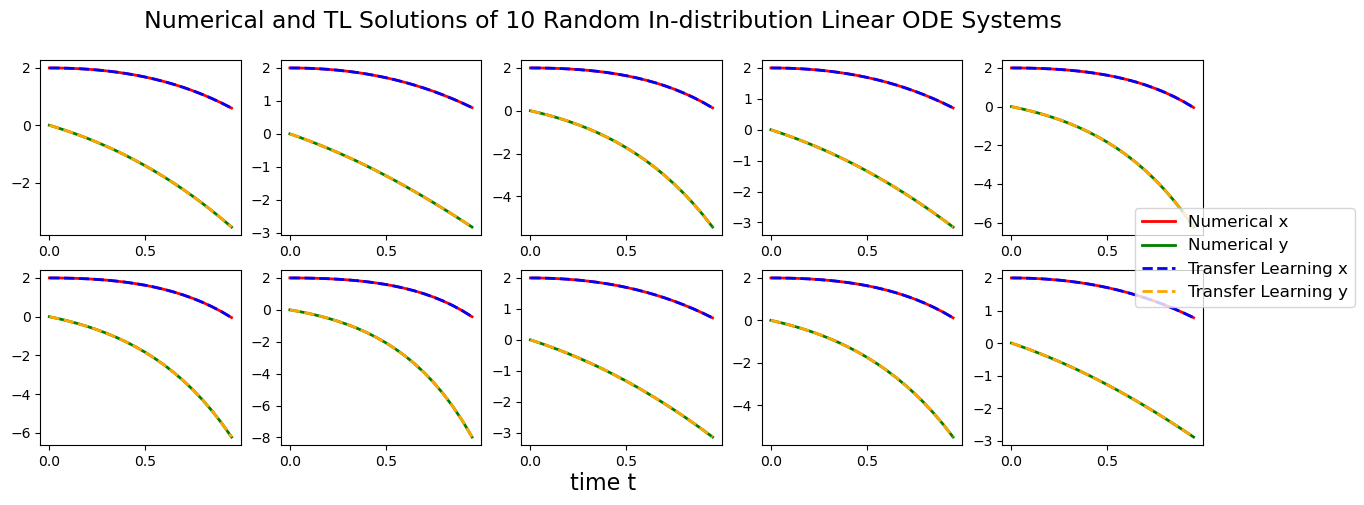

In [419]:
fig, ax = plt.subplots(2, 5, figsize=(15, 5));
for i in range(10):
  j = i//5; l = i%5
  ax[j][l].plot(X_grid, new_solutions_numerical[i].y[0], c='red',label='Numerical x', lw=2);
  ax[j][l].plot(X_grid, new_solutions_numerical[i].y[1], c='green',label='Numerical y', lw=2);
  ax[j][l].plot(X_grid, new_solutions_TL[i][:,0], '--', c='blue', label="Transfer Learning x", lw=2);
  ax[j][l].plot(X_grid, new_solutions_TL[i][:,1], '--', c='orange', label='Transfer Learning y', lw=2);
  #ax[j][l].legend(fontsize=6);
fig.supxlabel('time t', fontsize=16, ha='center');
fig.suptitle("Numerical and TL Solutions of 10 Random In-distribution Linear ODE Systems",
             fontsize=17);
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1.4),
           prop={'size': 12});
#plt.savefig(path+'10_indistribution_solutions_5000_lr2e-4_B200_gammad96_every100.eps', format='eps')

In [420]:
print("Using alpha={}, below is the loss statistics for all 10 new parameters:".format(Alpha))
for i in range(10):
  print("Parameter set #{}".format(i+1))
  print("Total Loss: {}".format(TL_Losses[i][0]))
  print("Colocation Loss: {}".format(TL_Losses[i][1]))
  print("BC Loss: {}".format(TL_Losses[i][2]))
  print("===================================")

Using alpha=1, below is the loss statistics for all 10 new parameters:
Parameter set #1
Total Loss: 9.046438828937625e-08
Colocation Loss: 6.1656898322836e-08
BC Loss: 2.5995256002724462e-14
Parameter set #2
Total Loss: 8.106480942687376e-08
Colocation Loss: 7.584828967670637e-08
BC Loss: 3.7697674338530326e-14
Parameter set #3
Total Loss: 2.2032301829405722e-07
Colocation Loss: 1.0199299859951474e-07
BC Loss: 7.910554349771629e-15
Parameter set #4
Total Loss: 8.406773274478803e-08
Colocation Loss: 6.68143224630602e-08
BC Loss: 5.813849515037734e-14
Parameter set #5
Total Loss: 3.577199548821737e-07
Colocation Loss: 1.5077874838863715e-07
BC Loss: 1.3342480676396906e-13
Parameter set #6
Total Loss: 3.532900235871407e-07
Colocation Loss: 1.4923439733723628e-07
BC Loss: 2.5395181140881556e-14
Parameter set #7
Total Loss: 9.353698993272758e-07
Colocation Loss: 3.4058137679538597e-07
BC Loss: 6.432479105983072e-14
Parameter set #8
Total Loss: 8.398162288648256e-08
Colocation Loss: 6.697473

## Try to Solve the Van Der Pols Equation

In [573]:
alpha = 3; _lambda = 0.5
domain = (0, 1.0); X_BOUNDARY = 2;
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.01))

In [574]:
##this function solves a Van der Pol Equation numerically
def solve_vanderpol(alpha, _lambda, u0, domain, t_eval):
  def F(t, y):
    return [y[1],
            alpha*y[1]- alpha*_lambda**2*y[0]**2*y[1] - y[0]]
  solution = solve_ivp(F, domain, u0, t_eval=t_eval)
  return solution

solution = solve_vanderpol(alpha, _lambda, [X_BOUNDARY/_lambda, 0/_lambda], domain, X_grid)

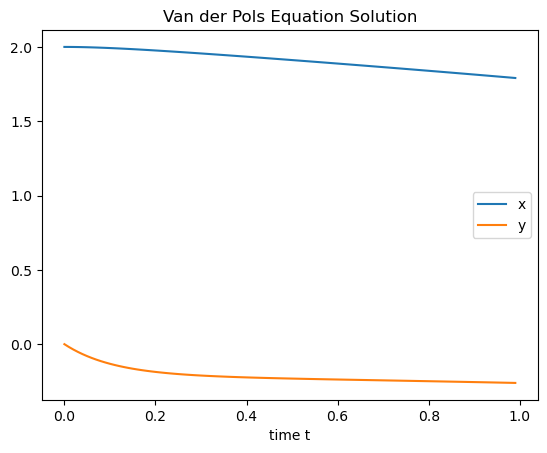

In [575]:
##plot the numerical solution
plt.plot(solution.t, solution.y[0]*_lambda, label='x');
plt.plot(solution.t, solution.y[1]*_lambda, label='y');
plt.xlabel("time t");
plt.title("Van der Pols Equation Solution");
plt.legend();

### How to set the initial values of the p system?

First idea is to make the initial values the same across all systems.

then we have:

$$x_0  = \frac{x^{(0)}}{\sum_{i=0}^p \beta^{i}}$$

In [596]:
##this function computes the uniform initial condition value for all p systems
def compute_initial(x0, beta, p):
  denominator = 0
  for i in range(p+1):
    denominator += beta**i
  return x0/denominator

def x0_function_decorator(W, params, tensor=False):
  def x0_function(x):
    if tensor:
      return hidden_state_vmap(x, params)[:, :256]@torch.from_numpy(W).float()
    return hidden_state_vmap(x, params).detach().numpy()[:, :256]@W
  return x0_function

def y0_function_decorator(W, params, tensor=False):
  def y0_function(x):
    if tensor:
      return hidden_state_vmap(x, params)[:, 256:]@torch.from_numpy(W).float()
    return hidden_state_vmap(x, params).detach().numpy()[:, 256:]@W
  return y0_function

def xi_function_decorator(W, tensor=False):
  def xi_function(x):
     if tensor:
        return hidden_state_vmap(x, new_params)[:, :256]@torch.from_numpy(W).float()
     return hidden_state_vmap(x, new_params).detach().numpy()[:, :256]@W
  return xi_function

def yi_function_decorator(W, tensor=False):
  def yi_function(x):
     if tensor:
        return hidden_state_vmap(x, new_params)[:, 256:]@torch.from_numpy(W).float()
     return hidden_state_vmap(x, new_params).detach().numpy()[:, 256:]@W
  return yi_function

def final_function_decorator(function_list, beta):
  def final_function(x):
    result = 0
    for i in range(len(function_list)):
      result += (beta**i)*function_list[i](x)
    return result
  return final_function

In [597]:
x = torch.linspace(domain[0] + (domain[1]-domain[0])/200, domain[1], 200)
alpha = 2
def force_decorator():
      def force(x):
        return torch.stack([torch.zeros_like(x), torch.zeros_like(x)]).T
      return force
##solve the first linear ODE system
##compute the matrix M; this M only need to be computed and inverted once
M = M_matrix(x, alpha, new_params, Alpha=1); Minv = np.linalg.pinv(M)
W = compute_W(x, alpha, new_params, Minv, force_decorator(), 1, Alpha=1, v0=0)

In [598]:
import time
##this function uses one-shot TL technique to solve the nonlinear Van der Pol equation (the x0' is set to 0)
##Parameters:
## x0: the initial value of the duffing equation
## lambda: parameter lamnda in the duffing equation
## p: number of linear systems to solve to approximate the Duffing Equation
## domain: the range at which the Duffing equation will be solved
## N: number of data points used to compute the result
## v0: initial velocity, default 0
def solve_vanderpol_TL(x0, _lambda, p, domain, N, alpha, params, v0=0,
                       Alpha=1, verbose=True, tensor=False):
  x0_initials = compute_initial(x0, _lambda, p)
  v0_initials = compute_initial(v0, _lambda, p)
  if verbose:
    print("Using uniform initial values of: x0={}, v0={}".format(x0_initials, v0_initials))
  x = torch.linspace(domain[0] + (domain[1]-domain[0])/N, domain[1], N)
  ##solve the first linear ODE system
  ##compute the matrix M; this M only need to be computed and inverted once
  M = M_matrix(x, alpha, params, Alpha=Alpha); Minv = np.linalg.pinv(M)
  ##define the initial forcing function
  def force_decorator():
      def force(x):
        return torch.stack([torch.zeros_like(x), torch.zeros_like(x)]).T
      return force
  F = force_decorator()
  ##compute the analytic W
  W = compute_W(x, alpha, params, Minv, F, x0_initials, Alpha=Alpha, v0=v0_initials)
  x0_function = x0_function_decorator(W, params, tensor=tensor)
  y0_function = y0_function_decorator(W, params, tensor=tensor)
  W_list = [W]; x_function_list = [x0_function]; y_function_list = [y0_function]
  ##solve the rest p linear ode system
  for i in range(1, p+1):
    if verbose:
      print("Solving the {}th linear ode system...".format(i))
    ##obtain the forcing function
    def force_function(x):
      if i==1:
        return torch.stack([torch.zeros_like(x), torch.zeros_like(x)]).T
      result = 0
      count = 0
      for j1 in range(p+1):
        for j2 in range(p+1):
          for j3 in range(p+1):
            if j1+j2+j3 == i-2:
              count += 1
              result -= alpha*x_function_list[j1](x)*x_function_list[j2](x)*y_function_list[j3](x) #elementwise multiplication
      if verbose:
        print(f"There are {count} composant in the force function")
      if tensor:
        tensor_zeros = torch.zeros((result.shape[0], 1), dtype=torch.float32)
        return torch.cat((tensor_zeros, result), dim=1)
      return np.hstack((np.zeros((result.shape[0], 1)), result))
    ##compute the analytic W
    s = time.time()
    W = compute_W(x, alpha, params, Minv, force_function, x0_initials, Alpha=Alpha, v0=v0_initials)
    e = time.time()
    if verbose:
      print(f"Time to compute W: {e-s:.2f}")
      print("=======================================================")
    ##obtain the function xi
    x_function_list.append(xi_function_decorator(W, tensor=tensor))
    y_function_list.append(yi_function_decorator(W, tensor=tensor))
    W_list.append(W)
  x_final_function = final_function_decorator(x_function_list, _lambda)
  y_final_function = final_function_decorator(y_function_list, _lambda)
  return x_final_function, y_final_function, x_function_list, y_function_list, W_list

In [649]:
p = 19
x_final_function, y_final_function, x_function_list, y_function_list, W_list = solve_vanderpol_TL(X_BOUNDARY/_lambda, _lambda, p, domain, 200,
                                                                                                  alpha, new_params)

Using uniform initial values of: x0=2.000001907350452, v0=0.0


Solving the 1th linear ode system...
Time to compute W: 0.98
Solving the 2th linear ode system...
There are 1 composant in the force function
Time to compute W: 1.13
Solving the 3th linear ode system...
There are 3 composant in the force function
Time to compute W: 0.95
Solving the 4th linear ode system...
There are 6 composant in the force function
Time to compute W: 0.77
Solving the 5th linear ode system...
There are 10 composant in the force function
Time to compute W: 0.86
Solving the 6th linear ode system...
There are 15 composant in the force function
Time to compute W: 0.95
Solving the 7th linear ode system...
There are 21 composant in the force function
Time to compute W: 1.04
Solving the 8th linear ode system...
There are 28 composant in the force function
Time to compute W: 1.71
Solving the 9th linear ode system...
There are 36 composant in the force function
Time to compute W: 1.38
Solving the 10th linear ode system...
There are 45 composant in the force function
Time to com

Plot all p+1 linear system solutions. The final solution will be the linear combination of these functions

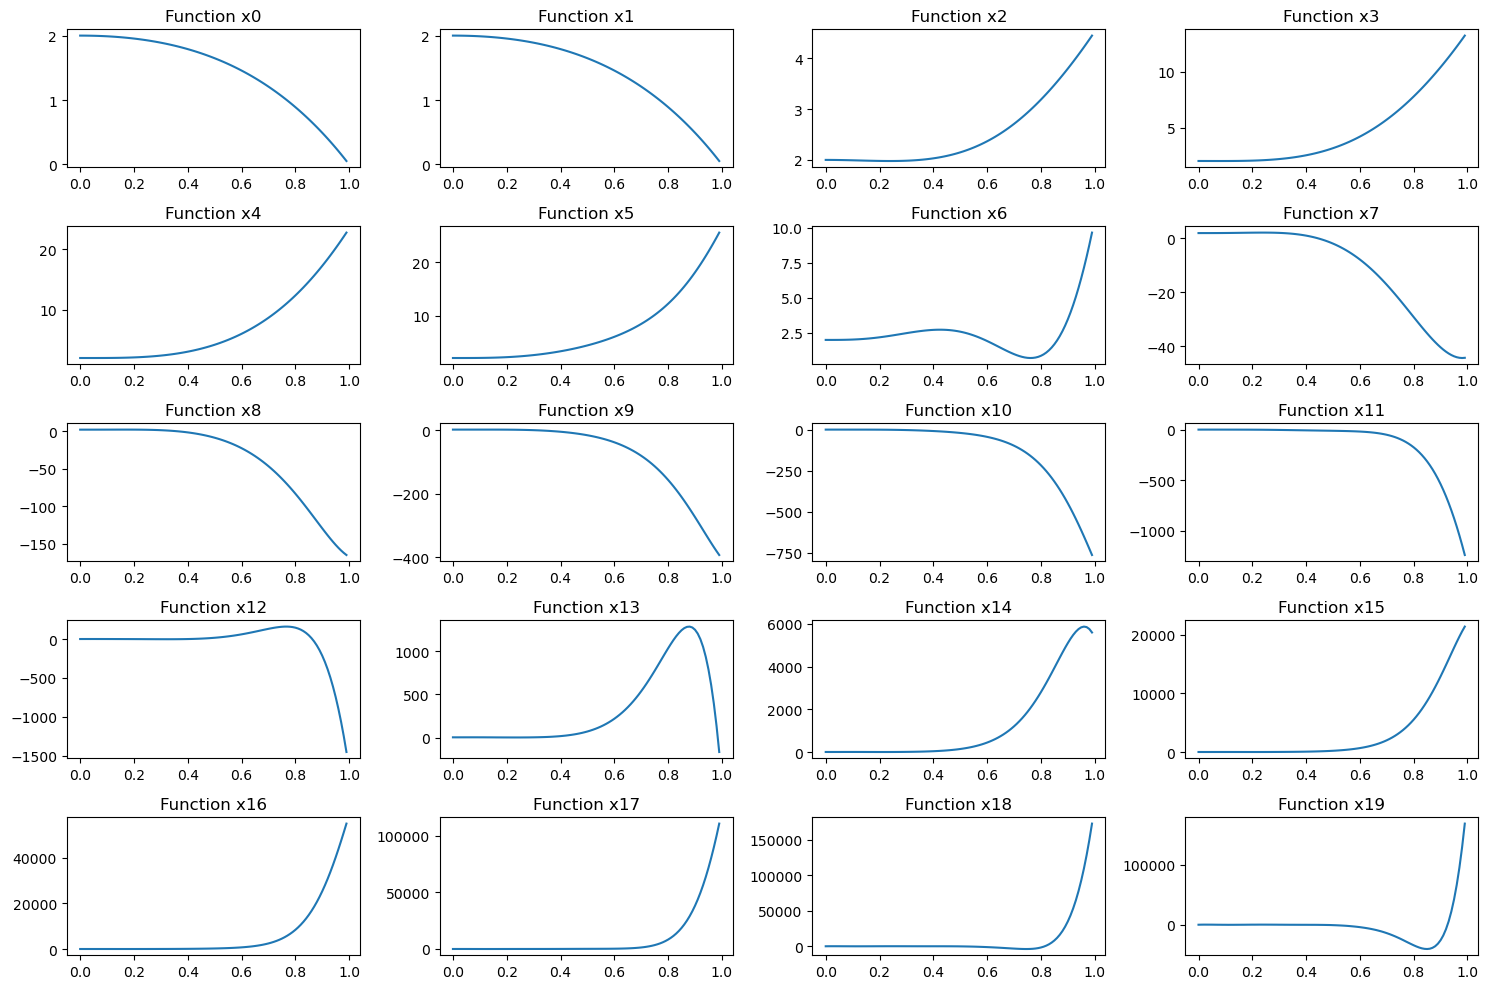

In [652]:
nb_row_plot = (p+1)//4+1 if (p+1)%4!=0 else (p+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2))
for i in range(len(x_function_list)):
  j = i//4; k = i%4
  ax[j][k].plot(X_grid, x_function_list[i](X_grid))
  ax[j][k].set_title("Function x{}".format(i))
fig.tight_layout()

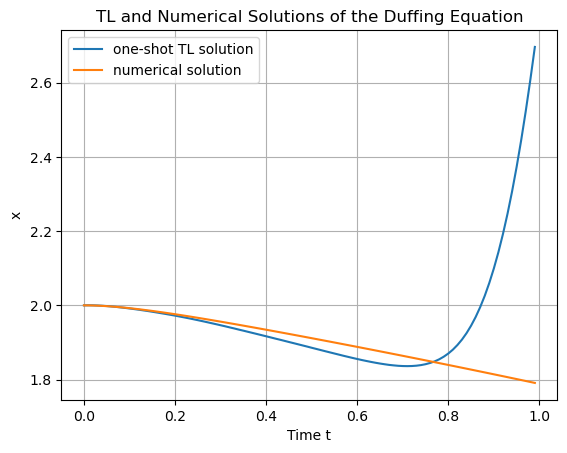

In [653]:
plt.plot(X_grid, x_final_function(X_grid)*_lambda, label='one-shot TL solution');
plt.plot(solution.t, solution.y[0]*_lambda, label='numerical solution');
plt.grid();
plt.xlabel("Time t");
plt.ylabel("x");
plt.title("TL and Numerical Solutions of the Duffing Equation");
plt.legend();

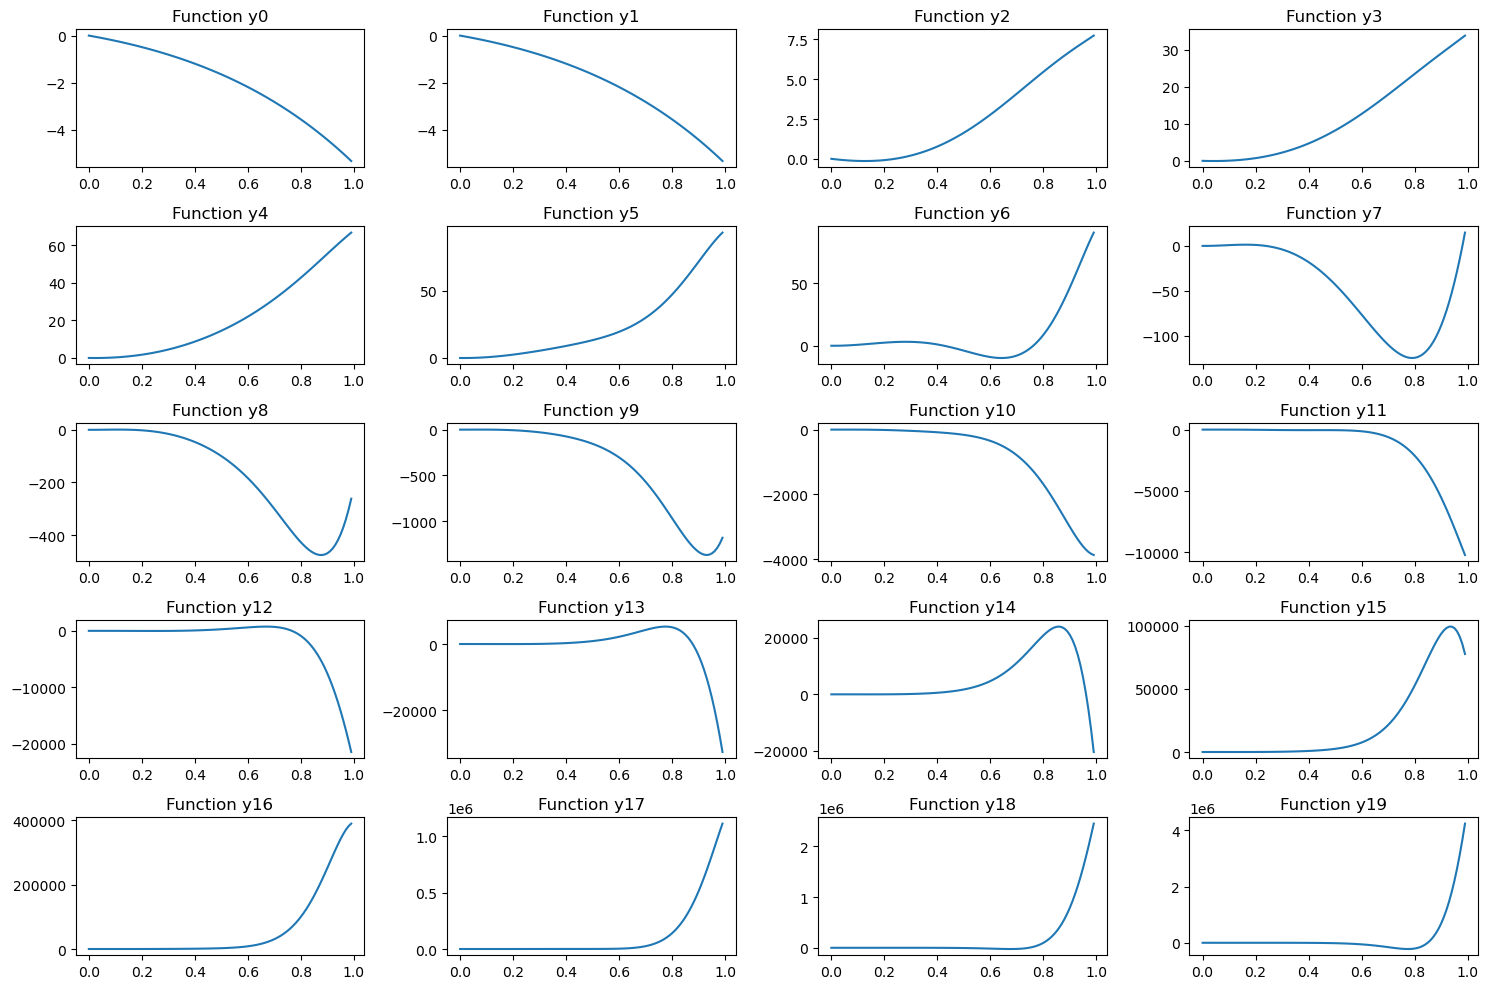

In [654]:
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2))
for i in range(len(y_function_list)):
  j = i//4; k = i%4
  ax[j][k].plot(X_grid, y_function_list[i](X_grid))
  ax[j][k].set_title("Function y{}".format(i))
fig.tight_layout()

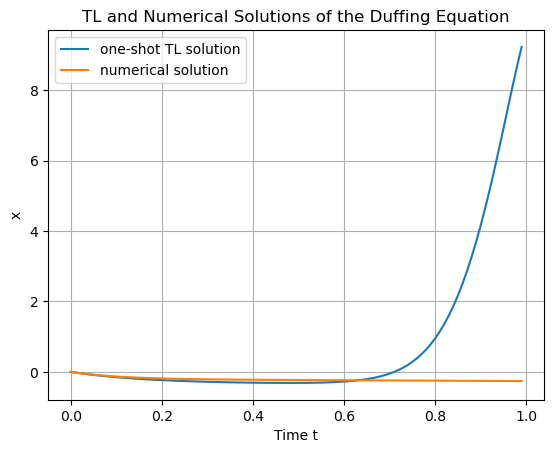

In [655]:
plt.plot(X_grid, y_final_function(X_grid)*_lambda, label='one-shot TL solution');
plt.plot(solution.t, solution.y[1]*_lambda, label='numerical solution');
plt.grid();
plt.xlabel("Time t");
plt.ylabel("x");
plt.title("TL and Numerical Solutions of the Duffing Equation");
plt.legend();

Use different values of p to test how the method performs with different p values.

In [656]:
P = 19
x_final_List = []; x_function_List_list = []; y_final_List = []; y_function_List_list = []; weights_list = []
for p in range(0, P+1):
  print("Solving p = {}".format(p))
  xff, yff, xfl, yfl, w = solve_vanderpol_TL(X_BOUNDARY/_lambda, _lambda, p, domain,
                                             200, alpha, new_params, verbose=False)
  x_final_List.append(xff)
  x_function_List_list.append(xfl)
  y_final_List.append(yff)
  y_function_List_list.append(yfl)
  weights_list.append(w)
  print()

Solving p = 0



Solving p = 1

Solving p = 2

Solving p = 3

Solving p = 4

Solving p = 5

Solving p = 6

Solving p = 7

Solving p = 8

Solving p = 9

Solving p = 10

Solving p = 11

Solving p = 12

Solving p = 13

Solving p = 14

Solving p = 15

Solving p = 16

Solving p = 17

Solving p = 18

Solving p = 19



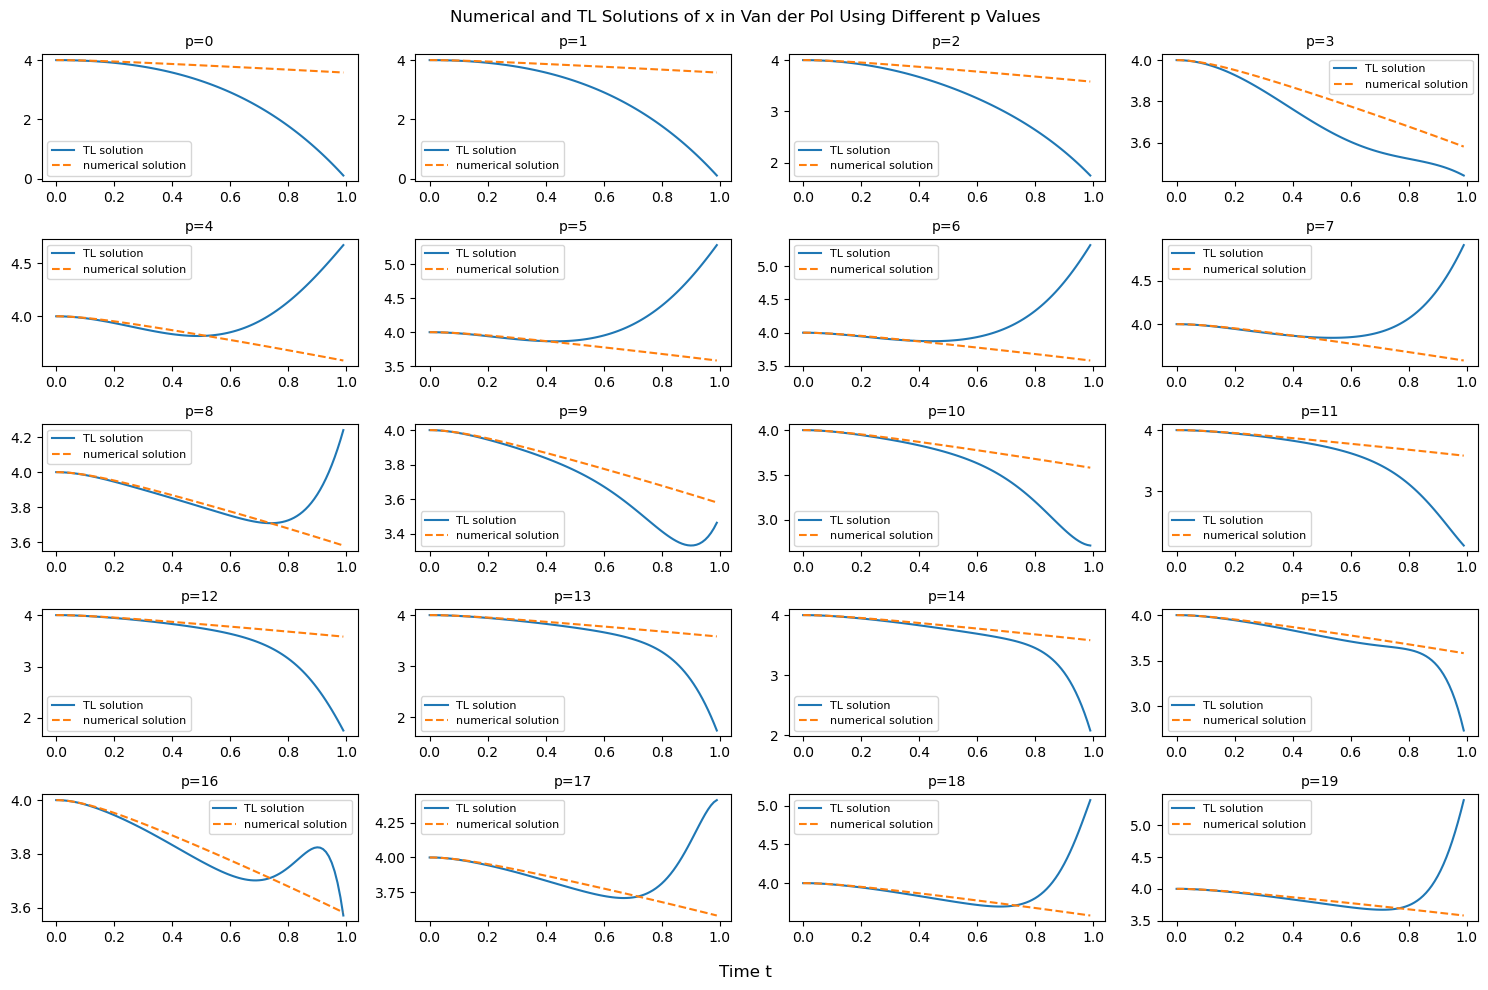

In [657]:
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2))
for i in range(len(x_final_List)):
  j = i//4; k = i%4
  ax[j][k].plot(X_grid, x_final_List[i](X_grid).flatten(), label='TL solution')
  ax[j][k].plot(solution.t, solution.y[0], '--', label='numerical solution')
  ax[j][k].legend(fontsize=8);
  ax[j][k].set_title("p={}".format(i), fontsize=10)
fig.supxlabel("Time t");
fig.suptitle("Numerical and TL Solutions of x in Van der Pol Using Different p Values");
fig.tight_layout()

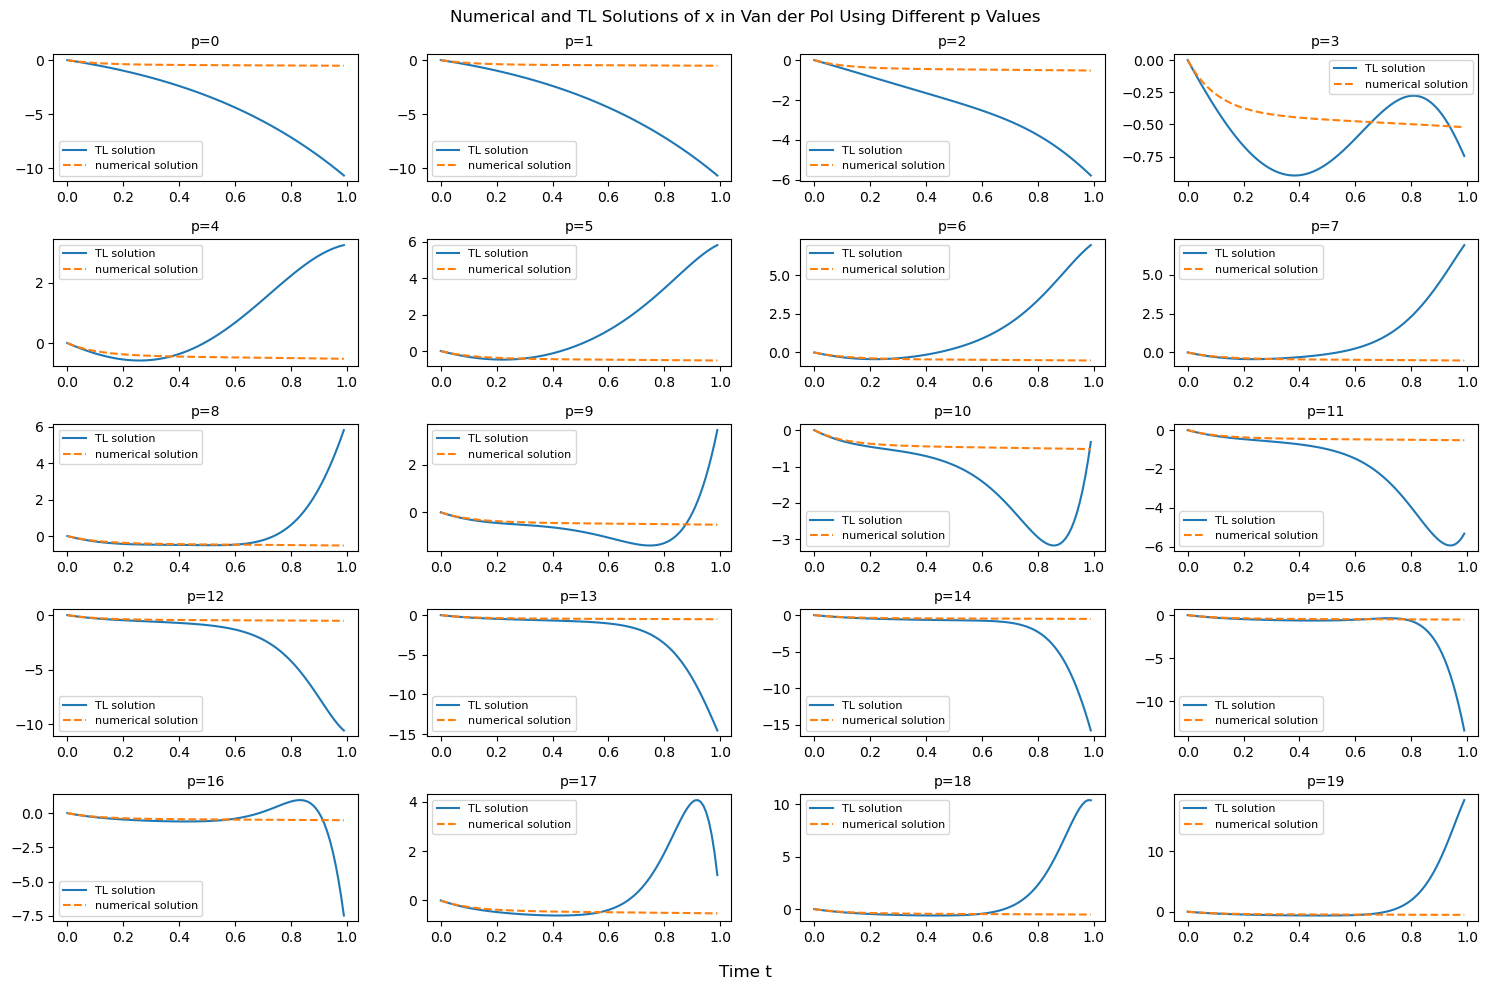

In [658]:
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2))
for i in range(len(y_final_List)):
  j = i//4; k = i%4
  ax[j][k].plot(X_grid, y_final_List[i](X_grid).flatten(), label='TL solution')
  ax[j][k].plot(solution.t, solution.y[1], '--', label='numerical solution')
  ax[j][k].legend(fontsize=8);
  ax[j][k].set_title("p={}".format(i), fontsize=10)
fig.supxlabel("Time t");
fig.suptitle("Numerical and TL Solutions of x in Van der Pol Using Different p Values");
fig.tight_layout()

# END

In [42]:
#this function computes the linear combination of the weight matrix W
def W_sum(W_list, beta, p):
  result = W_list[0].copy()
  for i in range(p):
    result += beta**(i+1)*W_list[i+1]
  return result

#x should be a tensor
#returns the final function value
def F(x, W_list, beta, p, params):
  Ws = W_sum(W_list, beta, p)
  H = hidden_state_vmap(x, new_params)
  return H[:,:256]@torch.from_numpy(Ws).float()

#computes and returns the first and second order derivative of F
def F_gradients(x, W_list, beta, p, params):
  Ws = W_sum(W_list, beta, p)
  H = hidden_state_vmap(x, new_params)
  y = H[:,:256]@torch.from_numpy(Ws).float()
  jac = torch.zeros(x.shape[0], x.shape[0])
  for i in range(x.shape[0]):
    gradient_i = torch.autograd.grad(y[i], x, create_graph=True)
    for j in range(x.shape[0]):
      jac[i,j] = gradient_i[0][j]
  first_order = torch.diag(jac)
  #compute second order derivative
  hessian = torch.zeros(x.shape[0], x.shape[0])
  for i in range(x.shape[0]):
    gradient2_i = torch.autograd.grad(first_order[i], x, create_graph=True)
    for j in range(x.shape[0]):
      hessian[i,j] = gradient2_i[0][j]
  second_order = torch.diag(hessian)
  return first_order.detach().numpy(), second_order.detach().numpy()

#this function computes and returns the non-linear Duffing loss
def Duffing_loss(x, W_list, beta, p, params, u0, delta, alpha, gamma,
                 omega):
  #compute the function value at x
  F_values = F(x, W_list, beta, p, params).detach().numpy().flatten()
  #compute its first and second order derivative
  dFdt, dFdtt = F_gradients(x, W_list, beta, p, params)
  #compute the forcing function
  forcing_term = gamma*np.cos(omega*x.detach().numpy())
  #compute the left hand side
  LHS = dFdtt + delta*dFdt + alpha*F_values + beta*F_values**3
  #compute the initial value
  F0 = F(torch.tensor([0.0], dtype=torch.float32), W_list, beta, p, params)
  return ((LHS - forcing_term)**2).mean() + ((F0 - u0)**2)[0].detach().numpy()[0]


In [ ]:
x = torch.linspace(0.02, 4.98, 100, requires_grad=True, dtype=torch.float32)
print("Duffing Loss: ")
Duffing_loss(x, W_list, beta, p, new_params, 1, delta, alpha, gamma, omega)

Duffing Loss: 


0.00019563682

In [ ]:
F_values = F(x, W_list, beta, p, params).detach().numpy().flatten()
dFdt, dFdtt = F_gradients(x, W_list, beta, p, params)

In [ ]:
forcing_term = gamma*np.cos(omega*x.detach().numpy())
#compute the left hand side
LHS = dFdtt + delta*dFdt + alpha*F_values + beta*F_values**3
#compute the initial value
F0 = F(torch.tensor([0.0], dtype=torch.float32), W_list, beta, p, params)

In [ ]:
((LHS - forcing_term)**2).mean() + ((F0 - 1)**2)[0].detach().numpy()[0]

0.00019563682

In [ ]:
Duffing_loss(x, W_list, beta, p, new_params, 1, delta, alpha, gamma, omega)

0.00019563682

We need a more quantitative measure of how different values of p perform. So we decide to compute the loss of each solution.

It is very hard to compute the ODE loss of the solution because the solution is a function of a linear combination of many neural network. Computing the second order derivative would be very hard.

It is also impossible to obtain the absolute analytic solution of the duffing equation. Therefore, we decide to use the MSE between the TL solution and the numerical solution as a measure to quantify how good the solution is.

In [ ]:
##this function computes the MSE between the TL solution and the numerical solution
##f is the function of solution handler
##solution is the numerical solution
def MSE_loss(f, solution):
  TL_solution = f(torch.Tensor(solution.t)).flatten()
  return ((TL_solution - solution.y[0])**2).mean()

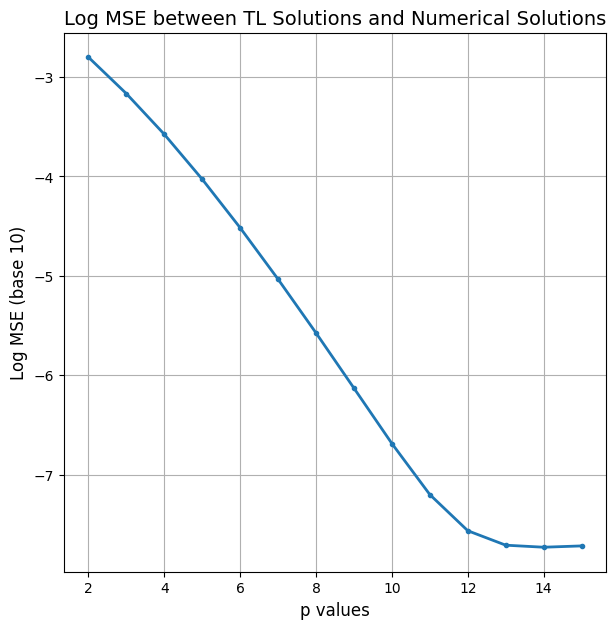

In [ ]:
##compute the MSE loss for all p values and plot them
mse_losts = []
for f in Final_List:
  mse_losts.append(MSE_loss(f, solution))

plt.figure(figsize=(7, 7));
plt.plot(range(2, len(Final_List)+2), np.log10(mse_losts), '.-', lw=2);
plt.grid();
plt.title("Log MSE between TL Solutions and Numerical Solutions", fontsize=14);
plt.xlabel("p values", fontsize=12);
plt.ylabel("Log MSE (base 10)", fontsize=12);
#plt.savefig(path+'logMSE_vs_p.eps', format='eps')

Attempt to compute the non-linear ODE loss

In [ ]:
L2 = Duffing_loss(x, weights_list[0], beta, 2, new_params, 1, delta, alpha, gamma, omega)

In [ ]:
duffing_losses = []
for p in range(2, 16):
  print(p)
  duffing_losses.append(Duffing_loss(x, weights_list[p-2],
                                beta, p, new_params, 1, delta, alpha, gamma, omega))

2
3
4
5
6
7
8
9
10
11
12
13
14
15


#### See How well Each of p Linear System is solved

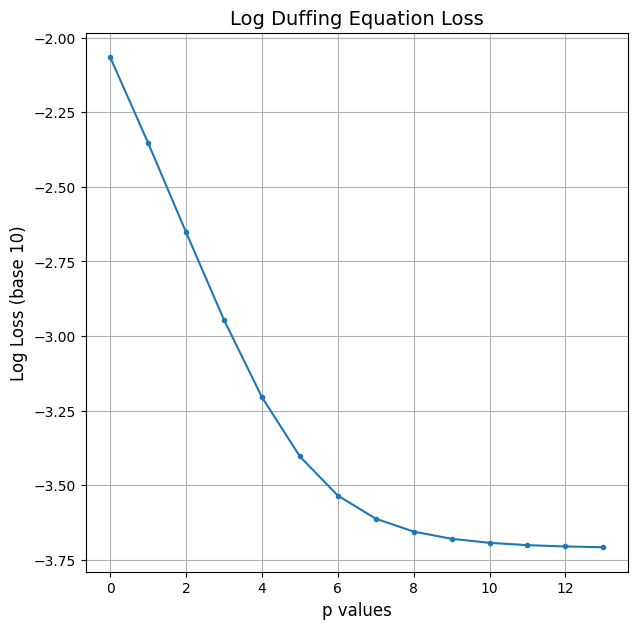

In [ ]:
plt.figure(figsize=(7, 7));
plt.plot(np.log10(duffing_losses), '.-');
plt.grid();
plt.title("Log Duffing Equation Loss", fontsize=14);
plt.xlabel("p values", fontsize=12);
plt.ylabel("Log Loss (base 10)", fontsize=12);
plt.savefig(path+'Duffing_loss.eps', format='eps')

In [ ]:
##this function computes the iterative forcing function in the ith linear ODE numerically
##using the computed function list by one-shot TL
def iterative_force_decorator(function_list, p, i):
  def force_function(x):
    result = 0
    for j1 in range(p+1):
      for j2 in range(p+1):
        for j3 in range(p+1):
          if j1+j2+j3 == i-1:
            result -= function_list[j1](x)*function_list[j2](x)*function_list[j3](x) #elementwise multiplication
    return np.hstack((np.zeros((result.shape[0], 1)), result))
  return force_function

##compute the iterative. forcing function for i from 1 to 15
iterative_forcing_list = [iterative_force_decorator(Function_List_list[-1], 15, i) for i in range(1, 16)]

NameError: ignored

Let's how each of the p forcing functions in the p linear systems look like.

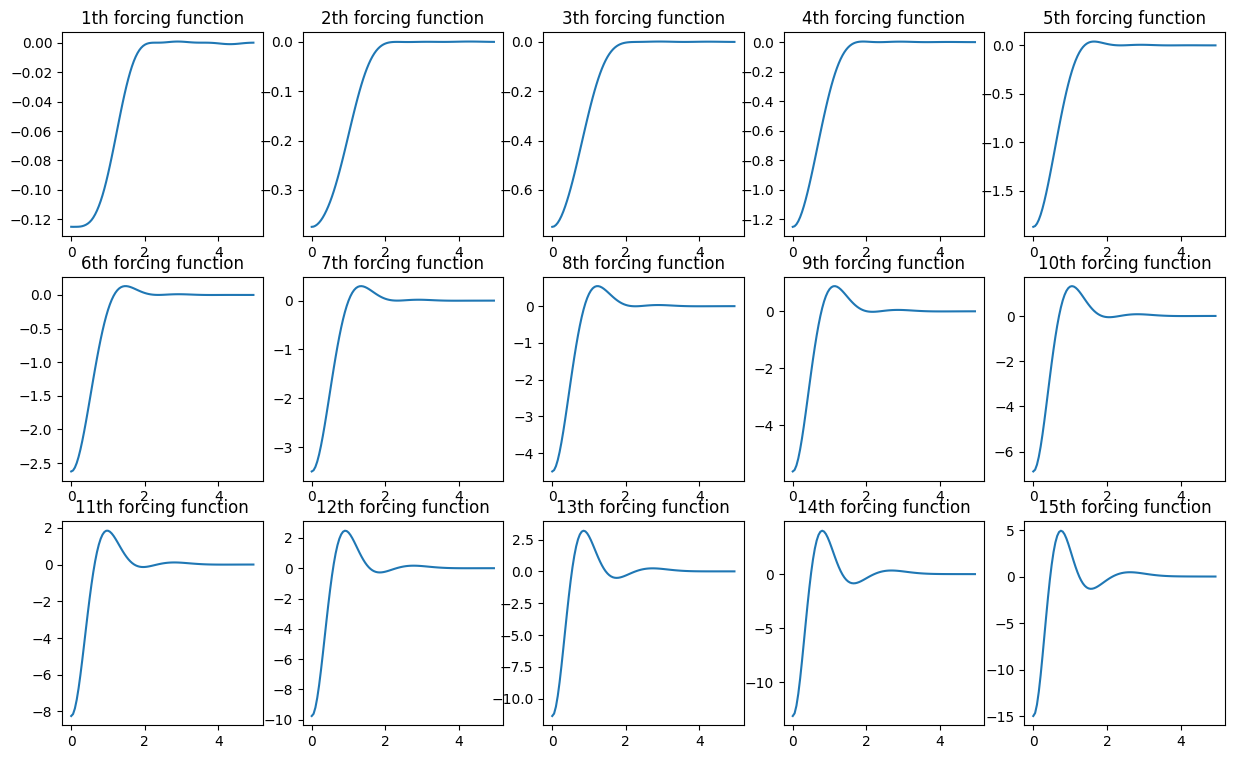

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(15, 9));
for i in range(len(iterative_forcing_list)):
  j = i//5; k = i%5
  ax[j][k].plot(X_grid, iterative_forcing_list[i](X_grid)[:,1])
  ax[j][k].set_title("{}th forcing function".format(i+1))

Let's compute and plot the TL loss of the p linear systems.

In [ ]:
## compute the loss of the p TL solutions
x = torch.linspace(domain[0] + (domain[1]-domain[0])/200, domain[1], 200)
boundary = compute_initial(X_BOUNDARY, beta, 15)
total_loss = []; colo_loss = []; BC_loss = []
for i in range(len(weights_list[-1])):
  if i == 0:
    F = None
  else:
    F = iterative_forcing_list[i-1]
  tl, cl, bl = loss_TL(x, new_params, alpha, delta,
            gamma, omega, weights_list[-1][i], boundary=boundary, F=F)
  total_loss.append(tl);
  colo_loss.append(cl);
  BC_loss.append(bl);

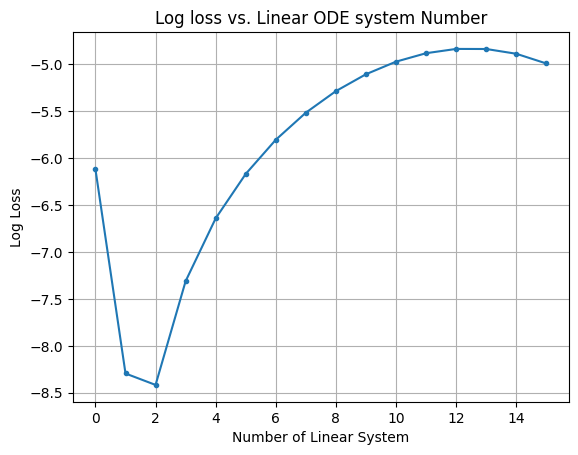

In [ ]:
plt.plot(range(16), np.log10(total_loss), '.-');
plt.grid();
plt.xlabel("Number of Linear System");
plt.ylabel("Log Loss");
plt.title("Log loss vs. Linear ODE system Number");

In [ ]:

Solution_list = []
iterative_forcing_list[0](torch.Tensor([1]))
for i in range(len(iterative_forcing_list)):
  print(i)
  #construct the forcing function
  def Fi(t):
    return iterative_forcing_list[i](torch.Tensor([t]))[0]
  def RHS_func(t, y):
    y = np.array(y)
    A_mat = np.array([[0, -1], [alpha, delta]])
    return -A_mat@y + Fi(t)
  ##solve the system numerically
  solution = solve_ivp(RHS_func, domain, np.array([compute_initial(X_BOUNDARY, beta, len(iterative_forcing_list)), 0]),
                       t_eval=X_grid)
  Solution_list.append(solution)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


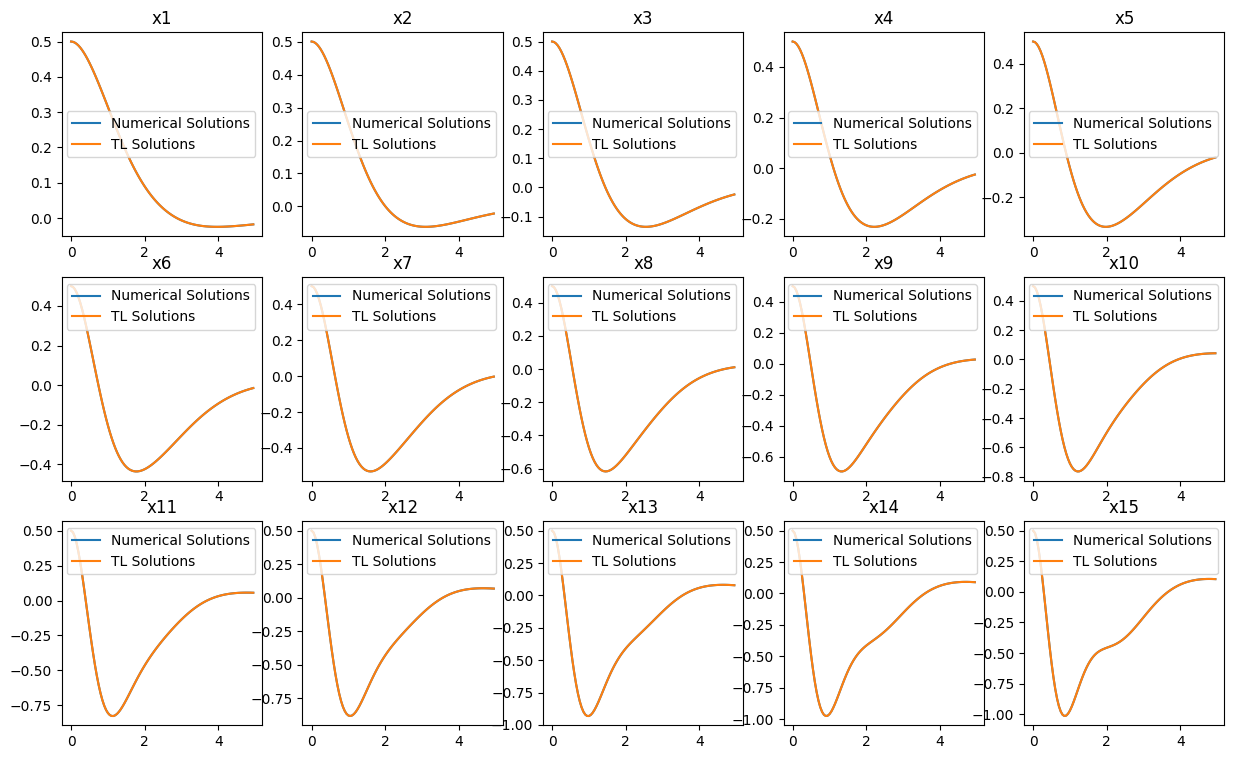

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(15, 9));
for i in range(15):
  j = i//5; k = i%5
  ax[j][k].plot(X_grid, Solution_list[i].y[0], label="Numerical Solutions")
  ax[j][k].plot(X_grid, Function_List_list[-1][i+1](X_grid).flatten(), label="TL Solutions")
  ax[j][k].set_title("x{}".format(i+1))
  ax[j][k].legend();

#### Try out different parameters of the Duffing Equation and see how the TL solver performs

Try out in-distribution parameters first. Fix $\beta$ to 0.5 first.

In [ ]:
##generate 20 random set of new parameters for Duffing equation

gamma_bounds = (0.5, 3)
w_bounds = (0.5, 3)
alpha_bounds = (0.5, 4.5)
delta_bounds = (0.5, 4.5)
boundary_bounds = (-3, 3)

Duffing_parameters = generate_parameters(20, gb = gamma_bounds,
                        wb = w_bounds, ab = alpha_bounds, db = delta_bounds,
                        bounds=boundary_bounds, seed=1)

In [ ]:
##solve these 20 Duffing equations numerically and using TL
nume_duff_solution = []
TL_duff_functions = []
TL_duff_solution = []
import time
s = time.time()
for i in range(20):
  print(i)
  delta = Duffing_parameters[0][i][3]
  alpha = Duffing_parameters[0][i][2]
  bd = Duffing_parameters[1][i]
  gamma = Duffing_parameters[0][i][0]
  omega = Duffing_parameters[0][i][1]
  #numerical solutions
  solu = solve_duffing(delta, alpha, 0.5,
                       lambda t: gamma*np.cos(omega*t),
                        [bd, 0], domain, X_grid)
  nume_duff_solution.append(solu)
  #TL solutions
  p=12
  ff, _, _ = solve_duffing_TL(bd, 0.5, p, domain, 200, alpha, delta, new_params, gamma, omega, verbose=False)
  TL_duff_functions.append(ff)
  TL_duff_solution.append(ff(X_grid.flatten()))
e  = time.time()
print(e-s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
1536.1210279464722


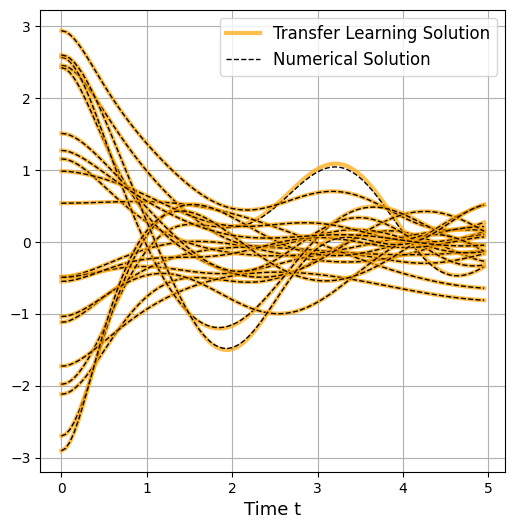

In [ ]:
plt.figure(figsize=(6, 6));
plt.plot()
for i in range(19):
  plt.plot(X_grid, TL_duff_solution[i], lw=3, c='orange', alpha=.7);
  plt.plot(nume_duff_solution[i].t, nume_duff_solution[i].y[0], '--', c='black', lw=1)
plt.plot(X_grid, TL_duff_solution[-1], lw=3, c='orange', alpha=.7, label='Transfer Learning Solution');
plt.plot(nume_duff_solution[-1].t, nume_duff_solution[-1].y[0], '--', c='black', lw=1,
         label='Numerical Solution');
plt.grid();
plt.legend(prop={'size': 12});
plt.xlabel("Time t", fontsize=13);
#plt.savefig(path+'20_indis_duffing_solutions_nonzero_v0_5000_lr2e-4_B200_gammad96_every100.eps',
            format='eps')

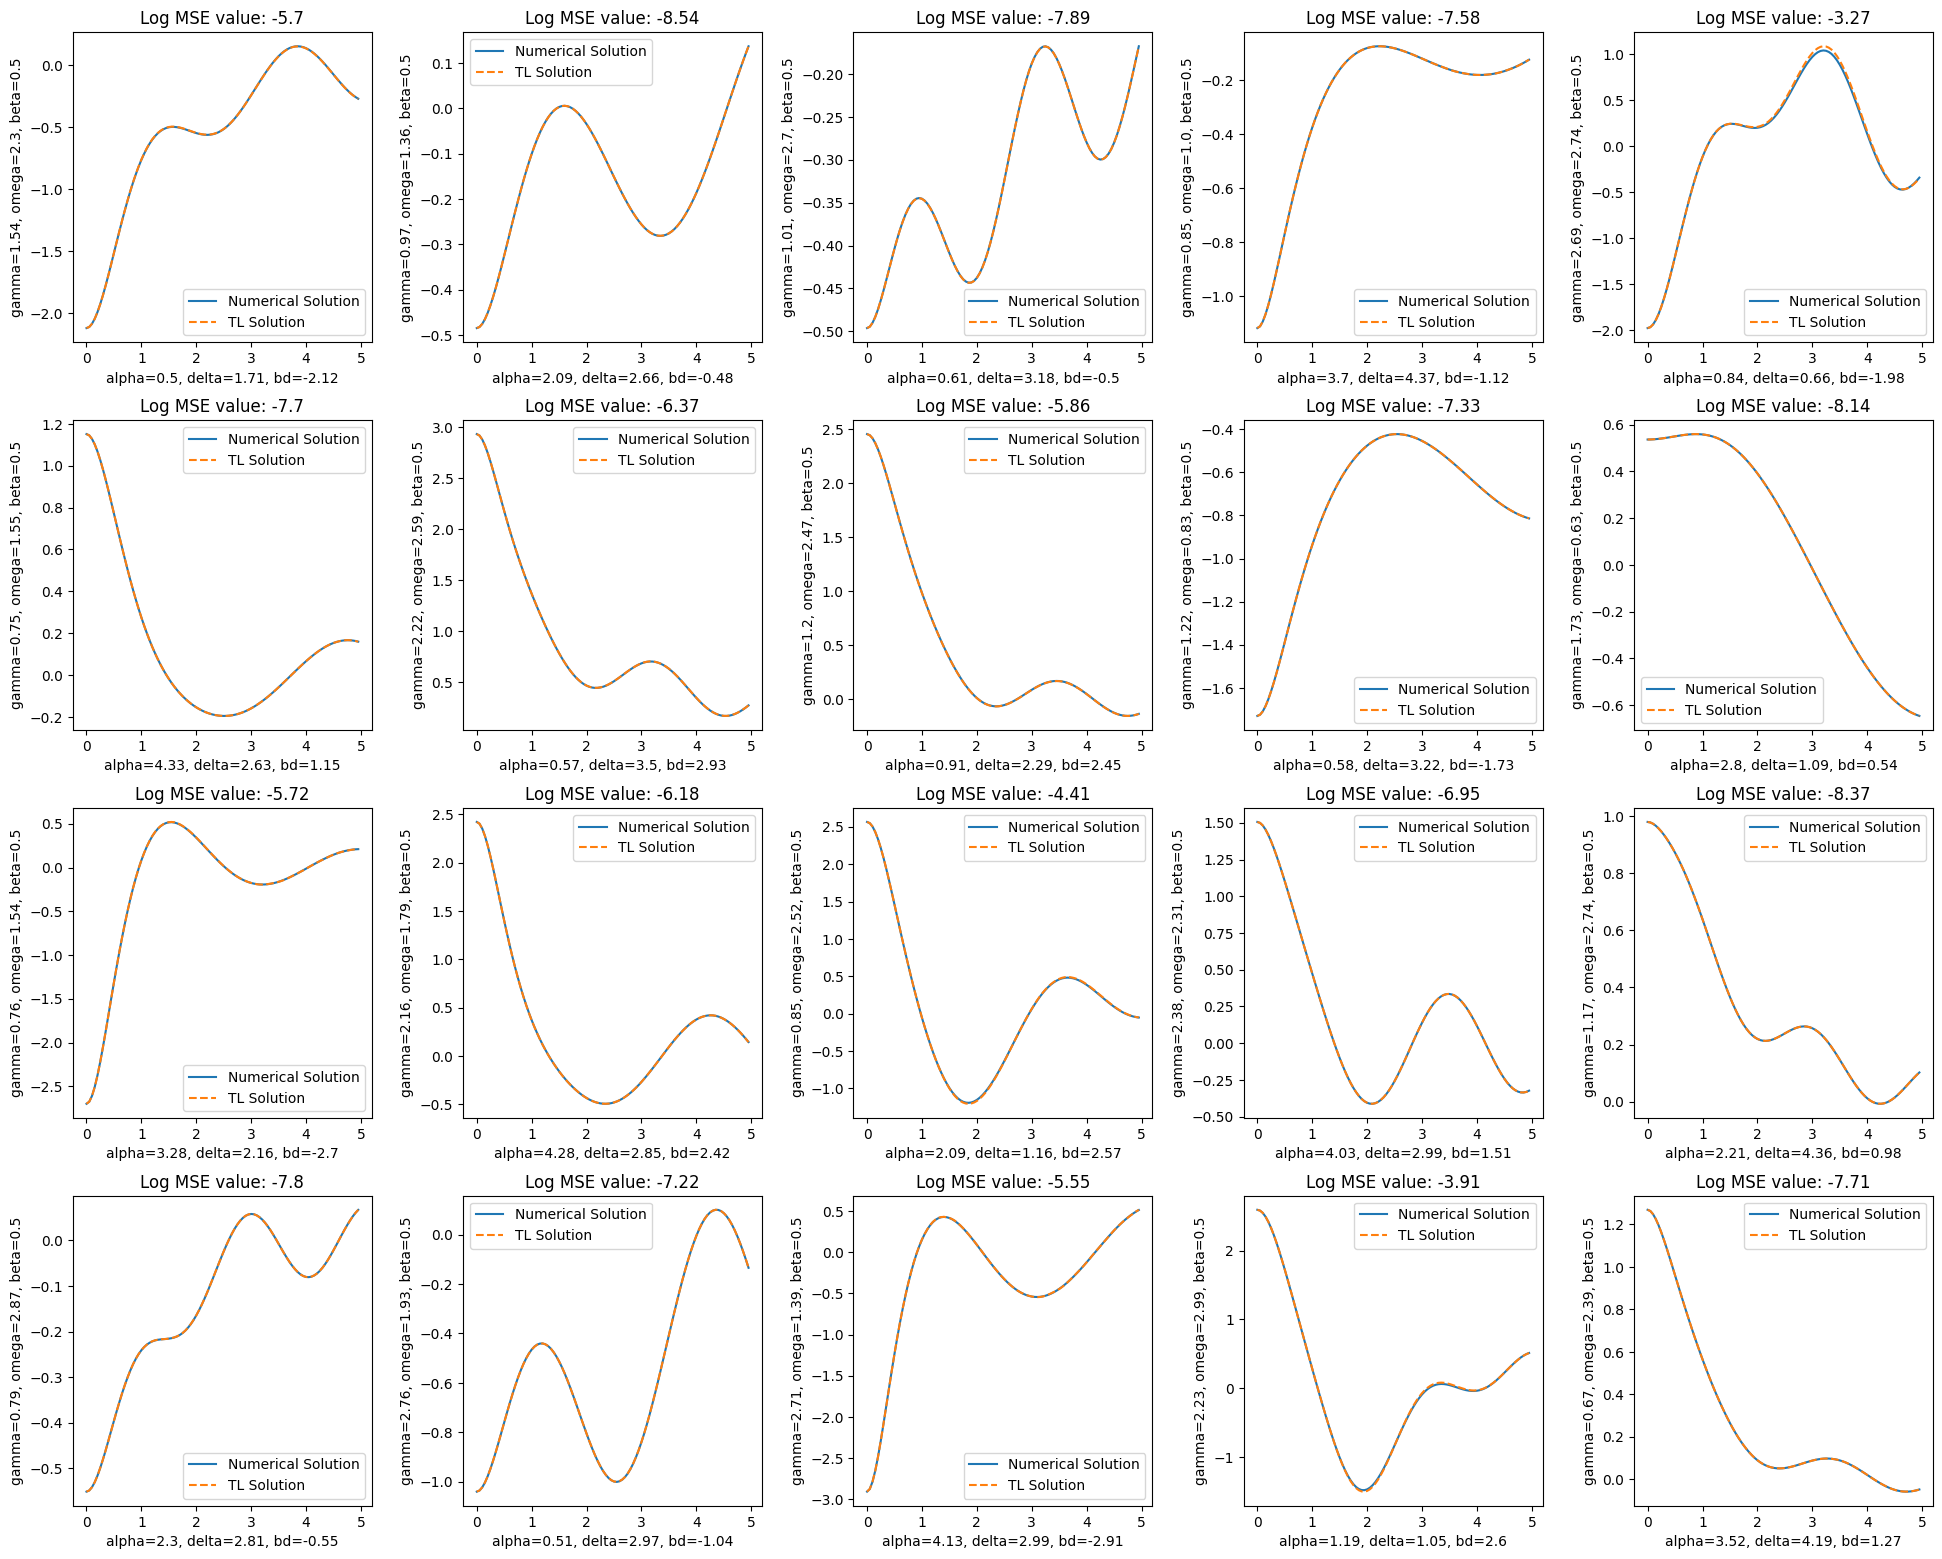

In [ ]:
##plot the solutions
fig, ax = plt.subplots(4, 5, figsize=(20, 16));
fig.tight_layout(pad=3.5)
for i in range(20):
  j = i//5; k = i%5
  ax[j][k].plot(nume_duff_solution[i].t, nume_duff_solution[i].y[0], label='Numerical Solution')
  ax[j][k].plot(X_grid, TL_duff_solution[i], '--', label='TL Solution')
  ##compute the MSE loss value
  loss = MSE_loss(TL_duff_functions[i], nume_duff_solution[i])
  ax[j][k].legend();
  ax[j][k].set_title("Log MSE value: " + str(round(np.log10(loss), 2)))
  ax[j][k].set_xlabel("alpha={}, delta={}, bd={}".format(round(Duffing_parameters[0][i][2], 2),
                                                 round(Duffing_parameters[0][i][3], 2),
                                                 round(Duffing_parameters[1][i], 2)))
  ax[j][k].set_ylabel("gamma={}, omega={}, beta={}".format(
      round(Duffing_parameters[0][i][0], 2),
      round(Duffing_parameters[0][i][1], 2),
      0.5
  ))
plt.savefig(path+'20_indistribution_duffing_solutions.eps', format='eps')

Setting one in-distribution parameters set and let $\beta$ vary and see how the solver performs.

In [ ]:
##use the original parameters set except for beta
delta = 1.5; alpha = 1; gamma = 0.5; omega = 2
domain = (0, 5.0); X_BOUNDARY = 1;
##define the range of beta we want to vary
Beta = np.arange(0.1, 2.1, 0.1)

In [ ]:
numerical_solutions = []; TL_functions = []; TL_solutions = []
for beta in Beta:
  print("beta: {}".format(beta))
  ##compute the numerical solutions
  solu = solve_duffing(delta, alpha, beta,
                       lambda t: gamma*np.cos(omega*t),
                        [X_BOUNDARY, 0], domain, X_grid)
  numerical_solutions.append(solu)
  ##compute the TL solutions
  p = 12
  ff, _, _ = solve_duffing_TL(X_BOUNDARY, beta, p, domain, 200, alpha, delta, new_params, gamma, omega, verbose=False)
  TL_functions.append(ff)
  TL_solutions.append(ff(X_grid.flatten()))

beta: 0.1
beta: 0.2
beta: 0.30000000000000004
beta: 0.4
beta: 0.5
beta: 0.6
beta: 0.7000000000000001
beta: 0.8
beta: 0.9
beta: 1.0
beta: 1.1
beta: 1.2000000000000002
beta: 1.3000000000000003
beta: 1.4000000000000001
beta: 1.5000000000000002
beta: 1.6
beta: 1.7000000000000002
beta: 1.8000000000000003
beta: 1.9000000000000001
beta: 2.0


In [ ]:
##compute the MSE loss for all betas
MSE_beta = []
for i, f in enumerate(TL_functions):
  MSE_beta.append(MSE_loss(f, numerical_solutions[i]))

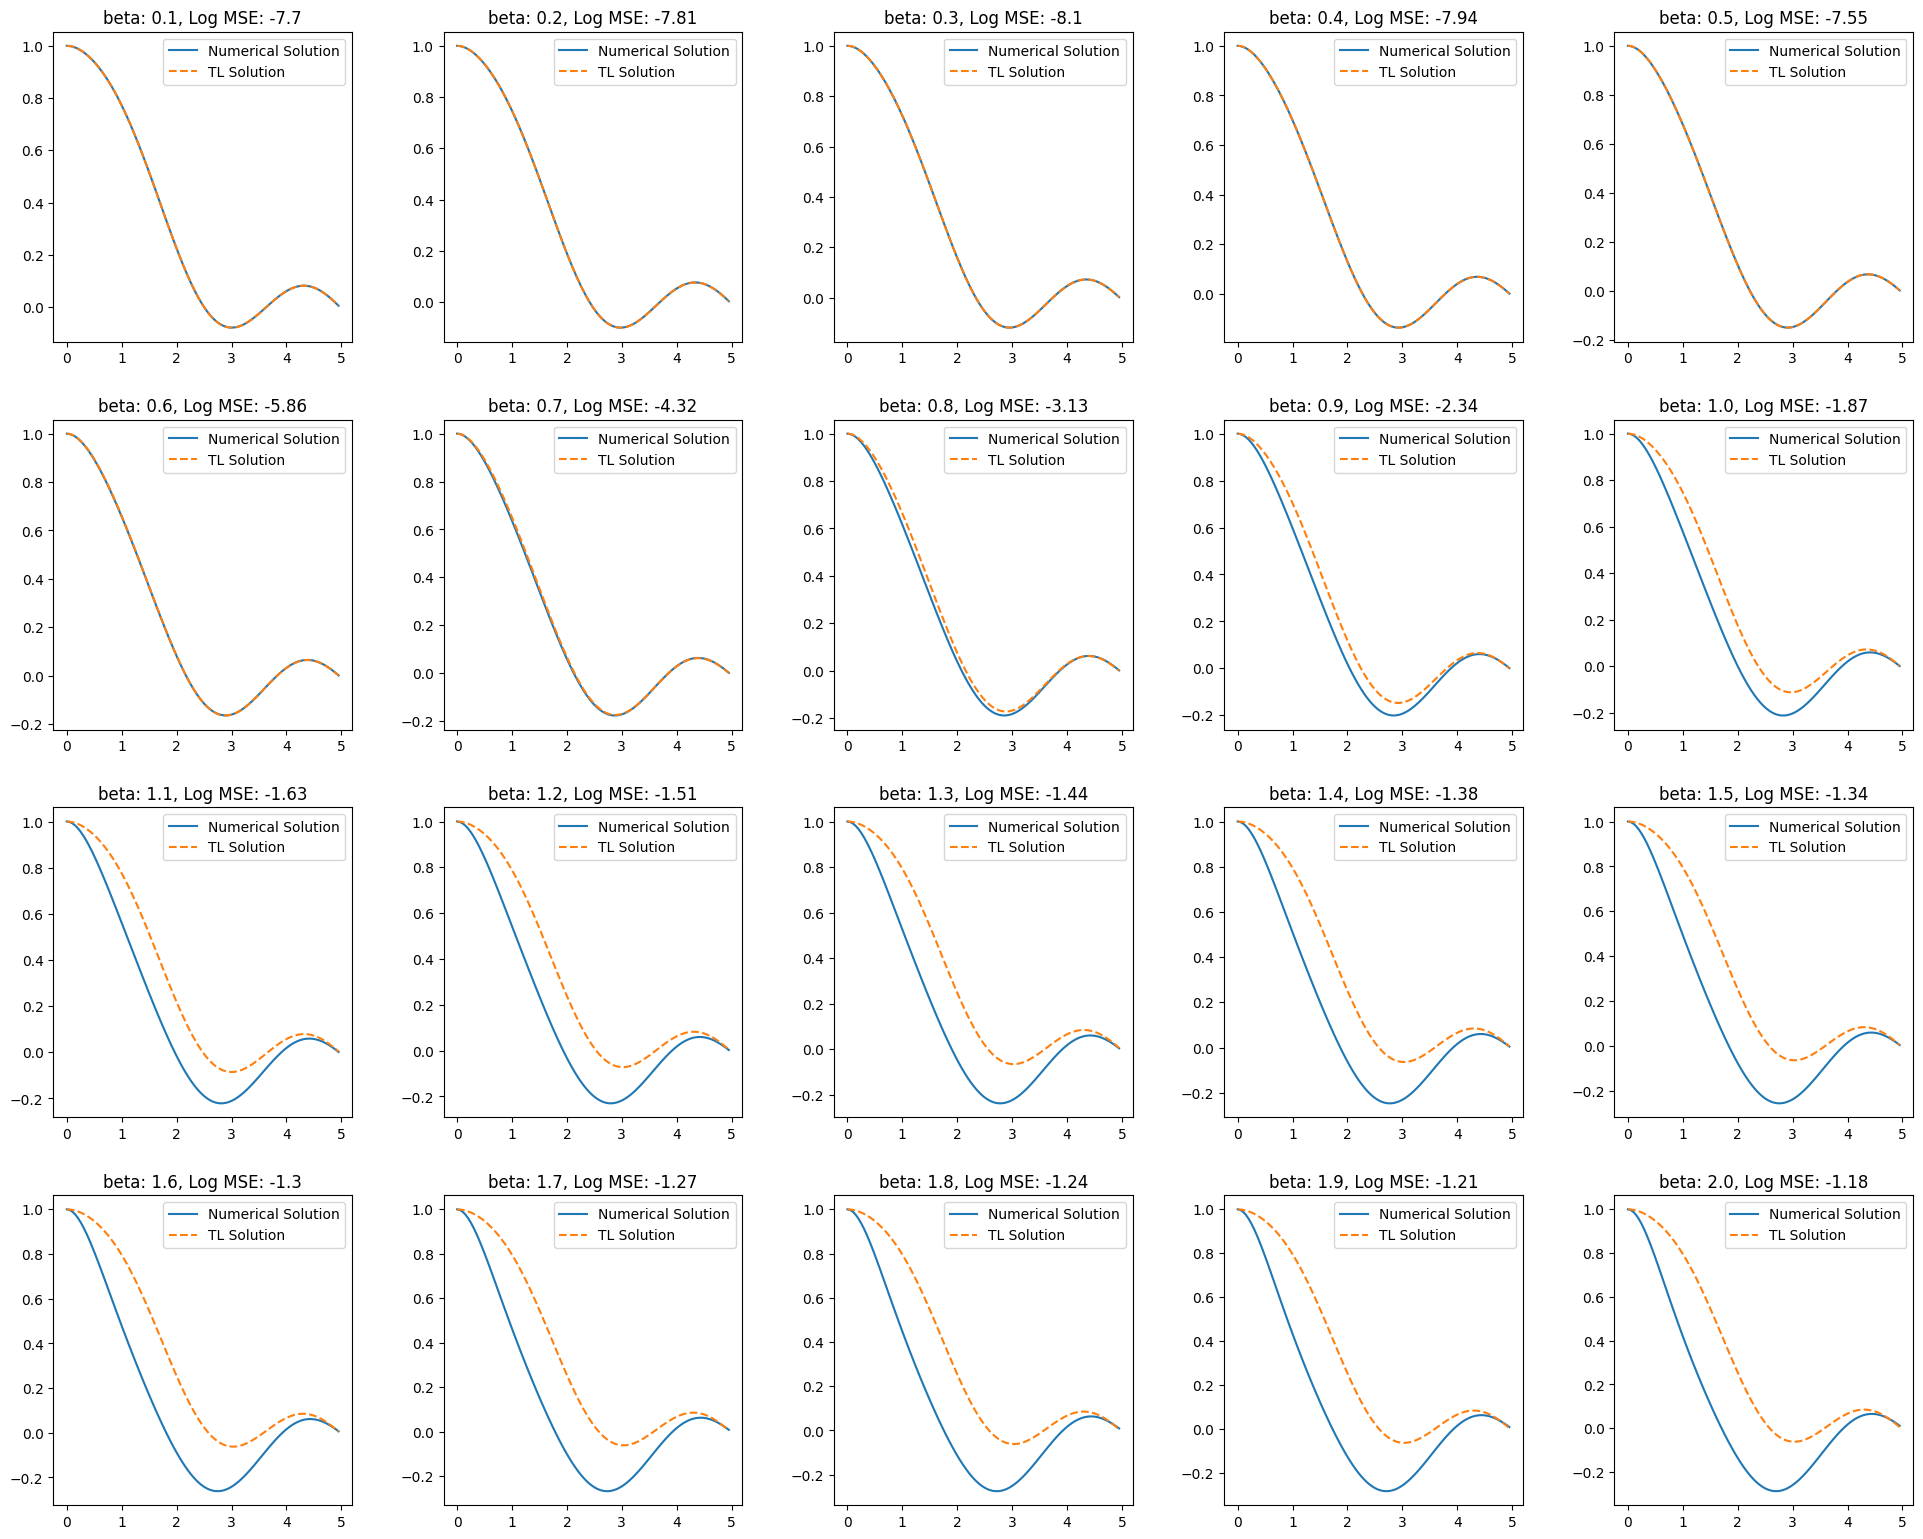

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(20, 16));
fig.tight_layout(pad=3.5)
for i in range(20):
  j = i//5; k = i%5
  ax[j][k].plot(numerical_solutions[i].t, numerical_solutions[i].y[0], label='Numerical Solution')
  ax[j][k].plot(X_grid, TL_solutions[i], '--', label="TL Solution")
  ax[j][k].legend()
  ax[j][k].set_title("beta: {}, Log MSE: {}".format(round(Beta[i], 1), round(np.log10(MSE_beta[i]), 2)))
plt.savefig(path+'betas_solutions.eps', format='eps')

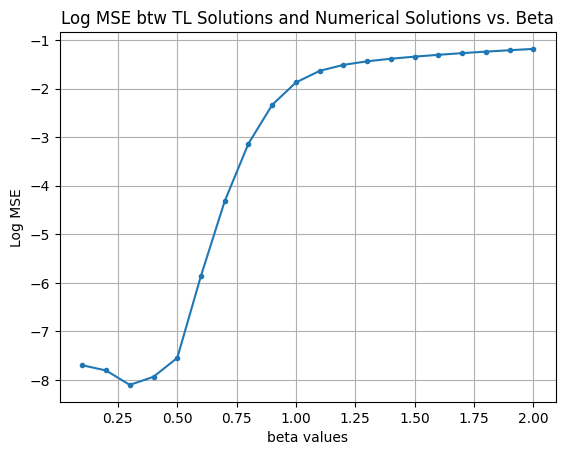

In [ ]:
plt.plot(Beta, np.log10(MSE_beta), '.-');
plt.grid();
plt.xlabel("beta values");
plt.ylabel("Log MSE");
plt.title("Log MSE btw TL Solutions and Numerical Solutions vs. Beta");
plt.savefig(path+'logMSE_vs_beta.eps', format='eps')

### Test how the solver performs as $\delta$ changes
Fix all parameters except for $\delta$, test how the solver performs when $\delta$ varies.

In [ ]:
##use the original parameters set except for delta
beta = 0.5; alpha = 1; gamma = 0.5; omega = 2
domain = (0, 5.0); X_BOUNDARY = 1;
##define the range of delta we want to vary
Delta = np.arange(0.1, 10.5, 0.5)

In [ ]:
numerical_delta = []; TL_functions_delta = []; TL_solutions_delta = []
for delta in Delta:
  print("delta: {}".format(delta))
  ##compute the numerical solutions
  solu = solve_duffing(delta, alpha, beta,
                       lambda t: gamma*np.cos(omega*t),
                        [X_BOUNDARY, 0], domain, X_grid)
  numerical_delta.append(solu)
  ##compute the TL solutions
  p = 12
  ff, _, _ = solve_duffing_TL(X_BOUNDARY, beta, p, domain, 200, alpha, delta, new_params, gamma, omega, verbose=False)
  TL_functions_delta.append(ff)
  TL_solutions_delta.append(ff(X_grid.flatten()))

delta: 0.1
delta: 0.6
delta: 1.1
delta: 1.6
delta: 2.1
delta: 2.6
delta: 3.1
delta: 3.6
delta: 4.1
delta: 4.6
delta: 5.1
delta: 5.6
delta: 6.1
delta: 6.6
delta: 7.1
delta: 7.6
delta: 8.1
delta: 8.6
delta: 9.1
delta: 9.6
delta: 10.1


In [ ]:
##compute the MSE loss for all deltas
MSE_delta = []
for i, f in enumerate(TL_functions_delta):
  MSE_delta.append(MSE_loss(f, numerical_delta[i]))

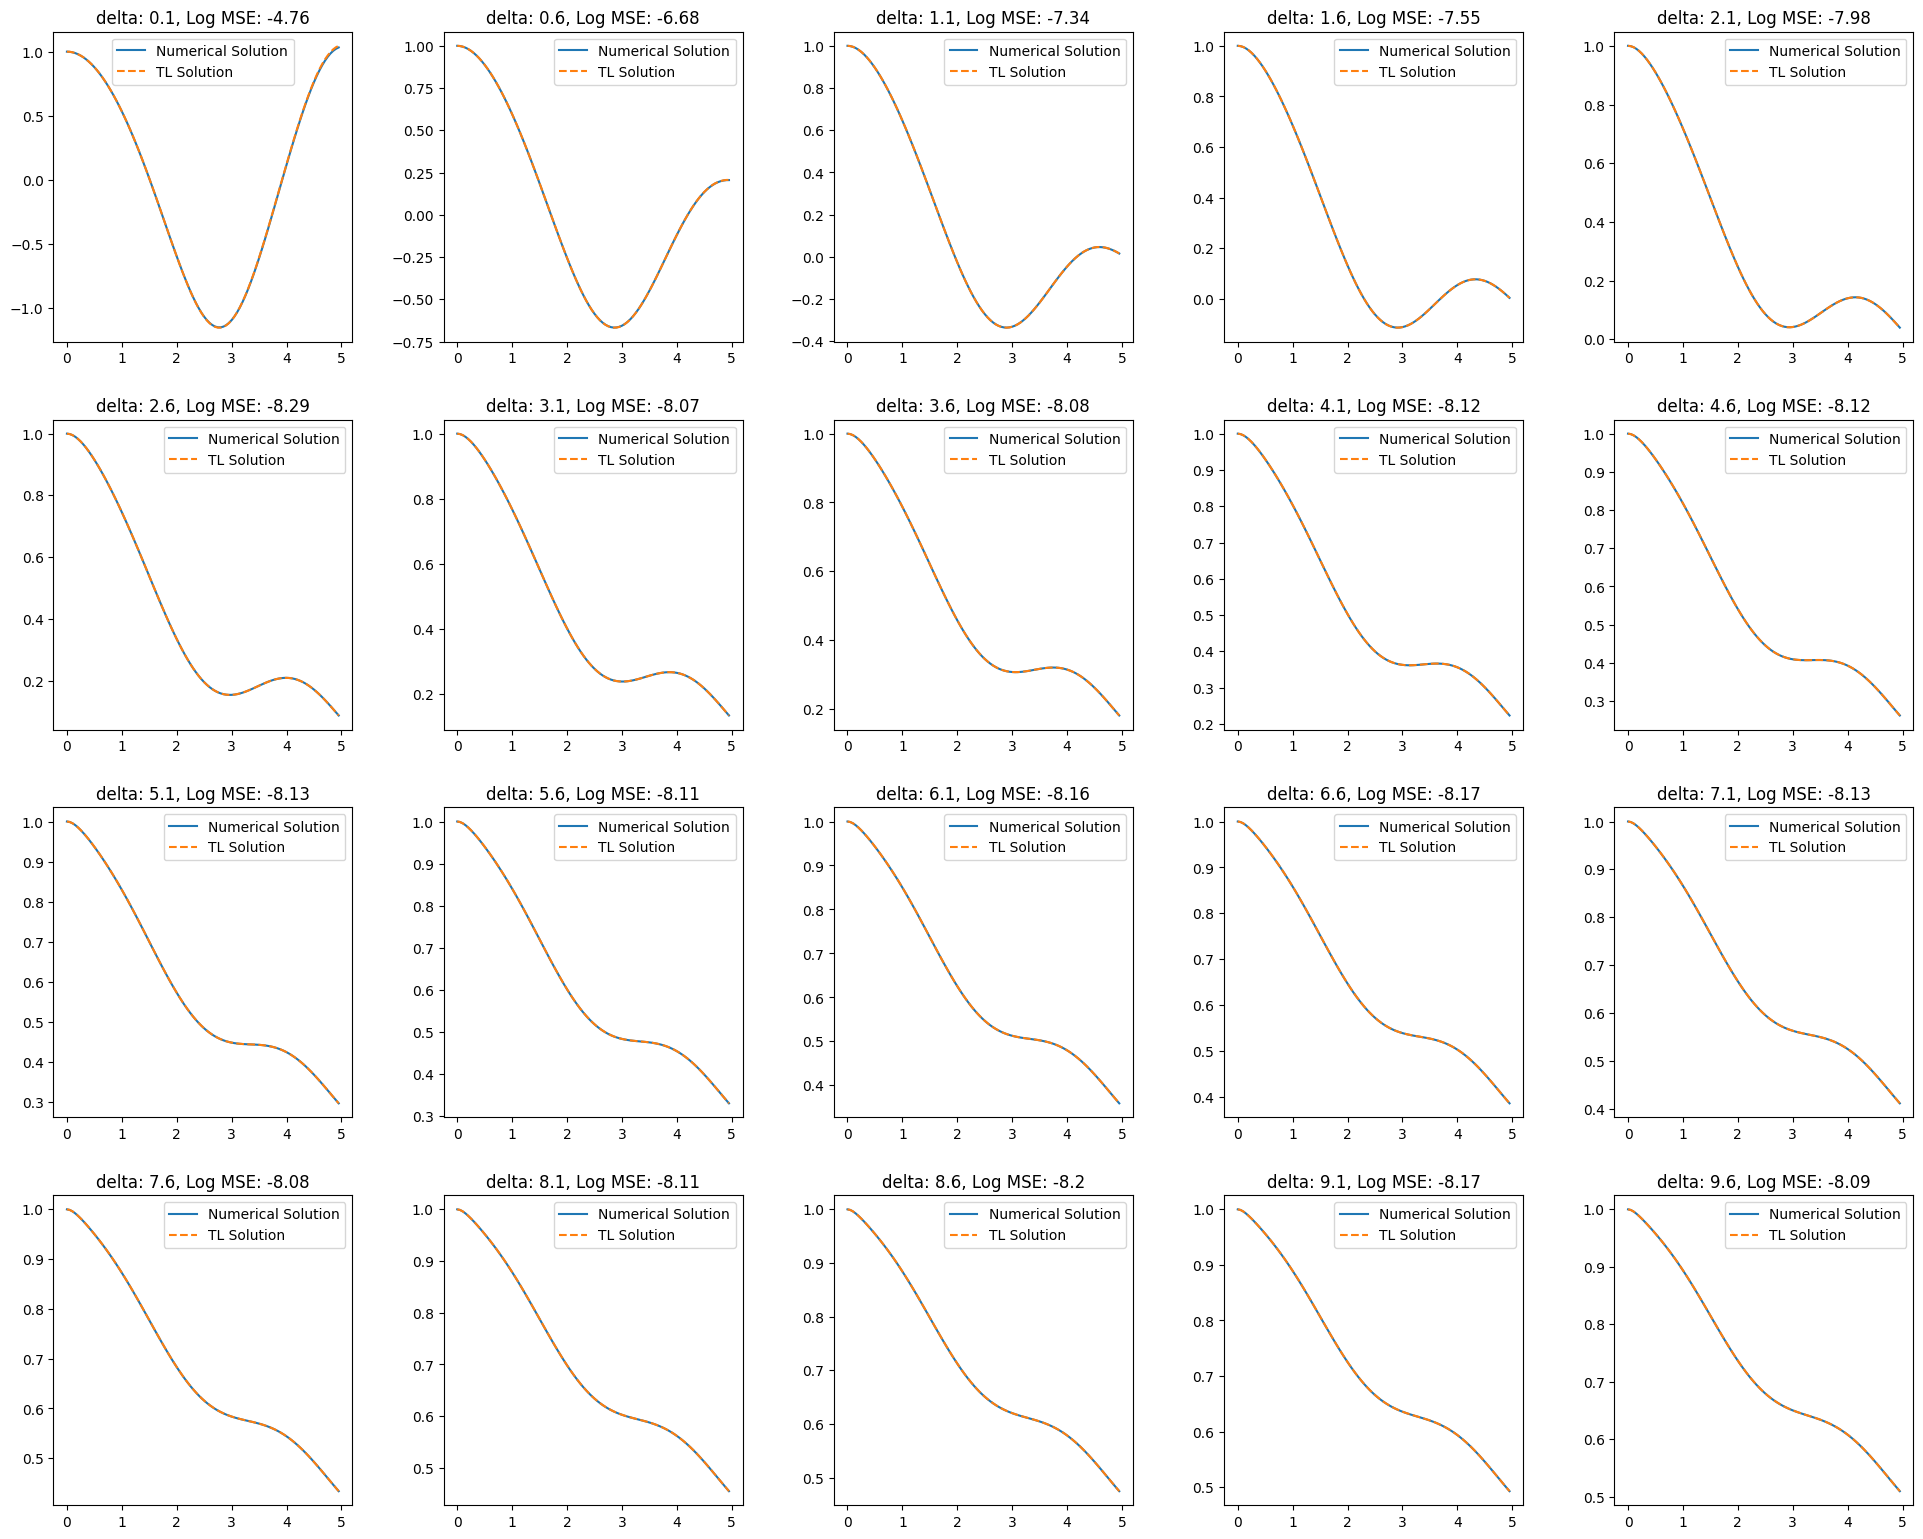

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(20, 16));
fig.tight_layout(pad=3.5)
for i in range(20):
  j = i//5; k = i%5
  ax[j][k].plot(numerical_delta[i].t, numerical_delta[i].y[0], label='Numerical Solution')
  ax[j][k].plot(X_grid, TL_solutions_delta[i], '--', label="TL Solution")
  ax[j][k].legend()
  ax[j][k].set_title("delta: {}, Log MSE: {}".format(round(Delta[i], 1), round(np.log10(MSE_delta[i]), 2)))
plt.savefig(path+'deltas_solutions.eps', format='eps')

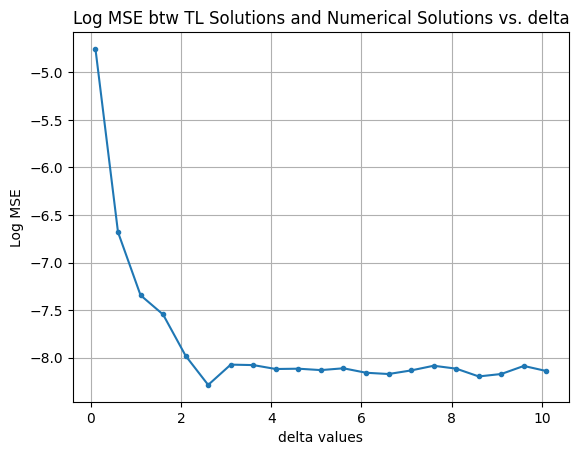

In [ ]:
plt.plot(Delta, np.log10(MSE_delta), '.-');
plt.grid();
plt.xlabel("delta values");
plt.ylabel("Log MSE");
plt.title("Log MSE btw TL Solutions and Numerical Solutions vs. delta");
plt.savefig(path+'logMSE_vs_delta.eps', format='eps')

### Test how the solver performs when $\alpha$ changes.


In [ ]:
delta = 1.5; beta = 0.5; gamma = 0.5; omega = 2
domain = (0, 5.0); X_BOUNDARY = 1;
##define the range of delta we want to vary
Alpha = np.arange(-10, 10.5, 0.5)

In [ ]:
numerical_alpha = []; TL_functions_alpha = []; TL_solutions_alpha = []
for alpha in Alpha:
  print("alpha: {}".format(alpha))
  ##compute the numerical solutions
  solu = solve_duffing(delta, alpha, beta,
                       lambda t: gamma*np.cos(omega*t),
                        [X_BOUNDARY, 0], domain, X_grid)
  numerical_alpha.append(solu)
  ##compute the TL solutions
  p = 12
  ff, _, _ = solve_duffing_TL(X_BOUNDARY, beta, p, domain, 200, alpha, delta, new_params, gamma, omega, verbose=False)
  TL_functions_alpha.append(ff)
  TL_solutions_alpha.append(ff(X_grid.flatten()))

alpha: -10.0
alpha: -9.5
alpha: -9.0
alpha: -8.5
alpha: -8.0
alpha: -7.5
alpha: -7.0
alpha: -6.5
alpha: -6.0
alpha: -5.5
alpha: -5.0
alpha: -4.5
alpha: -4.0
alpha: -3.5
alpha: -3.0
alpha: -2.5
alpha: -2.0
alpha: -1.5
alpha: -1.0
alpha: -0.5
alpha: 0.0
alpha: 0.5
alpha: 1.0
alpha: 1.5
alpha: 2.0
alpha: 2.5
alpha: 3.0
alpha: 3.5
alpha: 4.0
alpha: 4.5
alpha: 5.0
alpha: 5.5
alpha: 6.0
alpha: 6.5
alpha: 7.0
alpha: 7.5
alpha: 8.0
alpha: 8.5
alpha: 9.0
alpha: 9.5
alpha: 10.0


In [ ]:
##compute the MSE loss for all deltas
MSE_alpha = []
for i, f in enumerate(TL_functions_alpha):
  MSE_alpha.append(MSE_loss(f, numerical_alpha[i]))

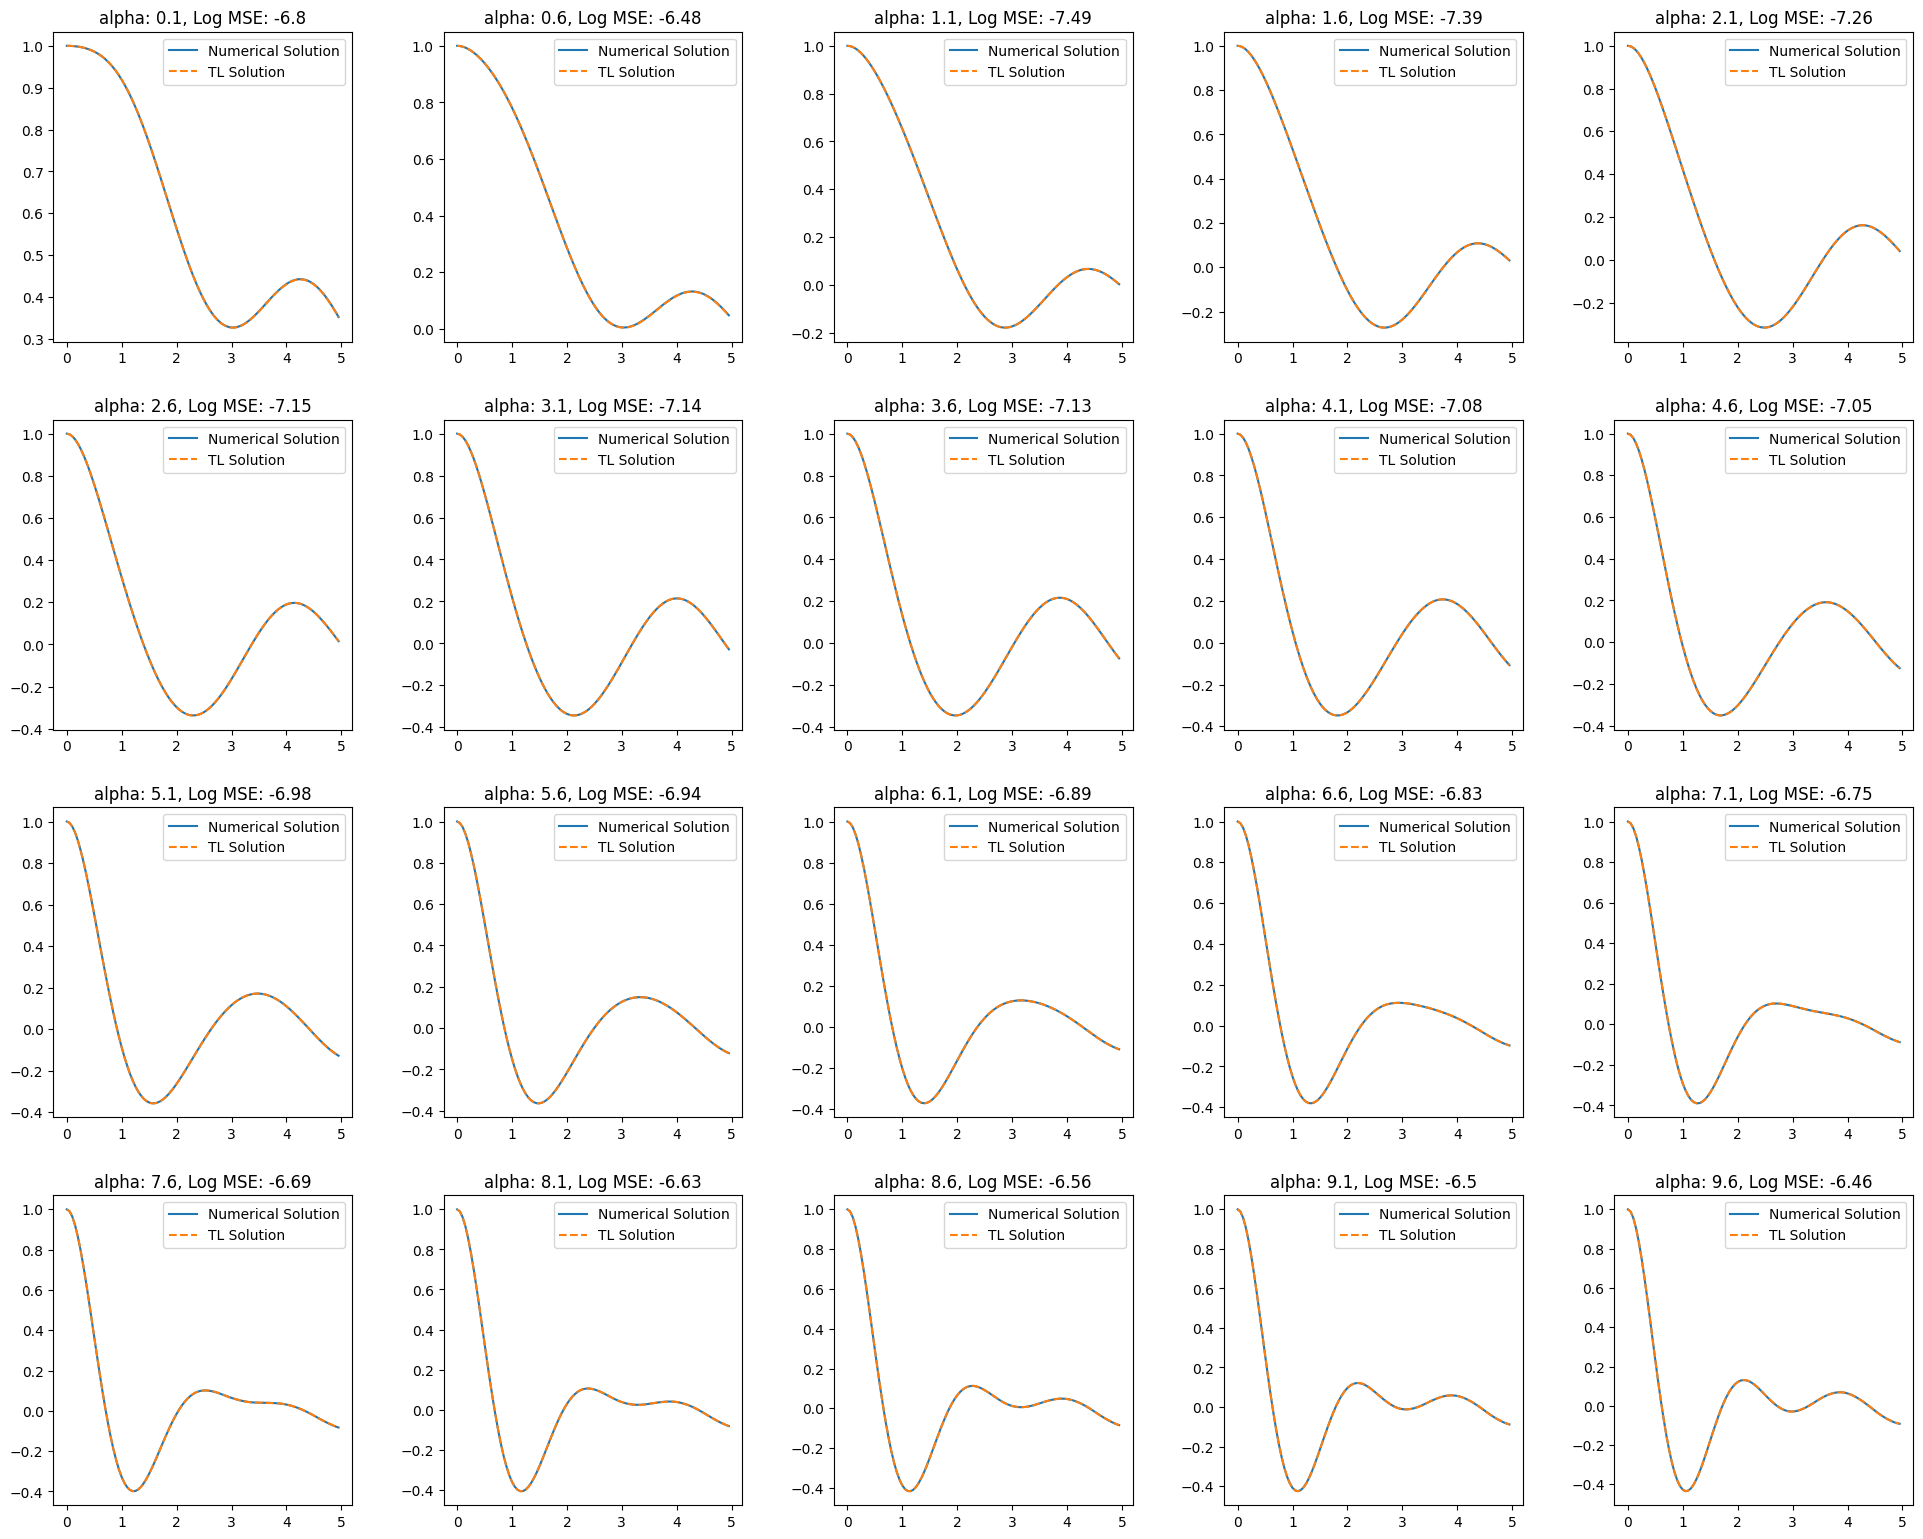

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(20, 16));
fig.tight_layout(pad=3.5)
for i in range(20):
  j = i//5; k = i%5
  ax[j][k].plot(numerical_alpha[i].t, numerical_alpha[i].y[0], label='Numerical Solution')
  ax[j][k].plot(X_grid, TL_solutions_alpha[i], '--', label="TL Solution")
  ax[j][k].legend()
  ax[j][k].set_title("alpha: {}, Log MSE: {}".format(round(Alpha[i], 1), round(np.log10(MSE_alpha[i]), 2)))
#plt.savefig(path+'alphas_solutions.eps', format='eps')

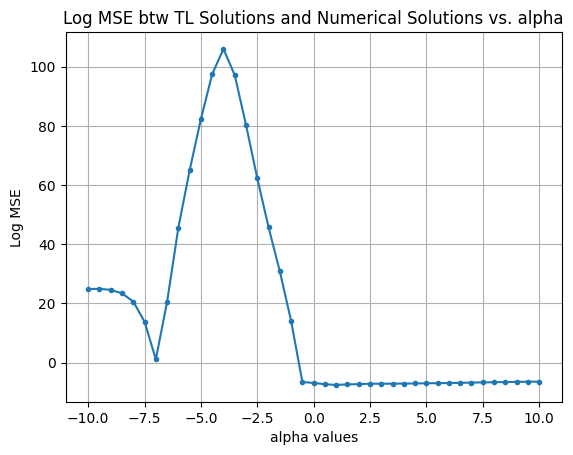

In [ ]:
plt.plot(Alpha, np.log10(MSE_alpha), '.-');
plt.grid();
plt.xlabel("alpha values");
plt.ylabel("Log MSE");
plt.title("Log MSE btw TL Solutions and Numerical Solutions vs. alpha");
plt.savefig(path+'logMSE_vs_alpha.eps', format='eps')

### Out of Distribution Performance
We will try 20 out of distribution parameter sets. The first 10 parameter sets are in this range:

$$
\gamma \in (-2, 0.5); \omega \in (-2, 0.5); \alpha \in (-3.5, 0.5); \delta \in (-3.5, 0.5); x_0 \in (-9, -3)
$$

The last 10 parameter sets are in this range:

$$
\gamma \in (3, 5.5); \omega \in (3, 5.5); \alpha \in (4.5, 8.5); \delta \in (4.5, 8.5); x_0 \in (3, 9)
$$

In [ ]:
gamma_bounds = (0.5, 3)
w_bounds = (0.5, 3)
alpha_bounds = (0.5, 4.5)
delta_bounds = (0.5, 4.5)
boundary_bounds = (-3, 3)

left_parameters = generate_parameters(10, gb = (-2, 0.5),
                        wb = (-2, 0.5), ab = (-3.5, 0.5), db = (-3.5, 0.5),
                        bounds=(-9, -3), seed=2)
right_parameters = generate_parameters(10, gb = (3, 5.5),
                        wb = (3, 5.5), ab = (4.5, 8.5), db = (4.5, 8.5),
                        bounds=(3, 9), seed=3)

out_parameters = (np.vstack((left_parameters[0], right_parameters[0])),
                  np.hstack((left_parameters[1], right_parameters[1])))

In [ ]:
##solve these 20 Duffing equations numerically and using TL
numerical_out = []
TL_functions_out = []
TL_solutions_out = []
for i in range(20):
  print(i)
  delta = out_parameters[0][i][3]
  alpha = out_parameters[0][i][2]
  bd = out_parameters[1][i]
  gamma = out_parameters[0][i][0]
  omega = out_parameters[0][i][1]
  #numerical solutions
  solu = solve_duffing(delta, alpha, 0.5,
                       lambda t: gamma*np.cos(omega*t),
                        [bd, 0], domain, X_grid)
  numerical_out.append(solu)
  #TL solutions
  p=12
  ff, _, _ = solve_duffing_TL(bd, 0.5, p, domain, 200, alpha, delta, new_params, gamma, omega, verbose=False)
  TL_functions_out.append(ff)
  TL_solutions_out.append(ff(X_grid.flatten()))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


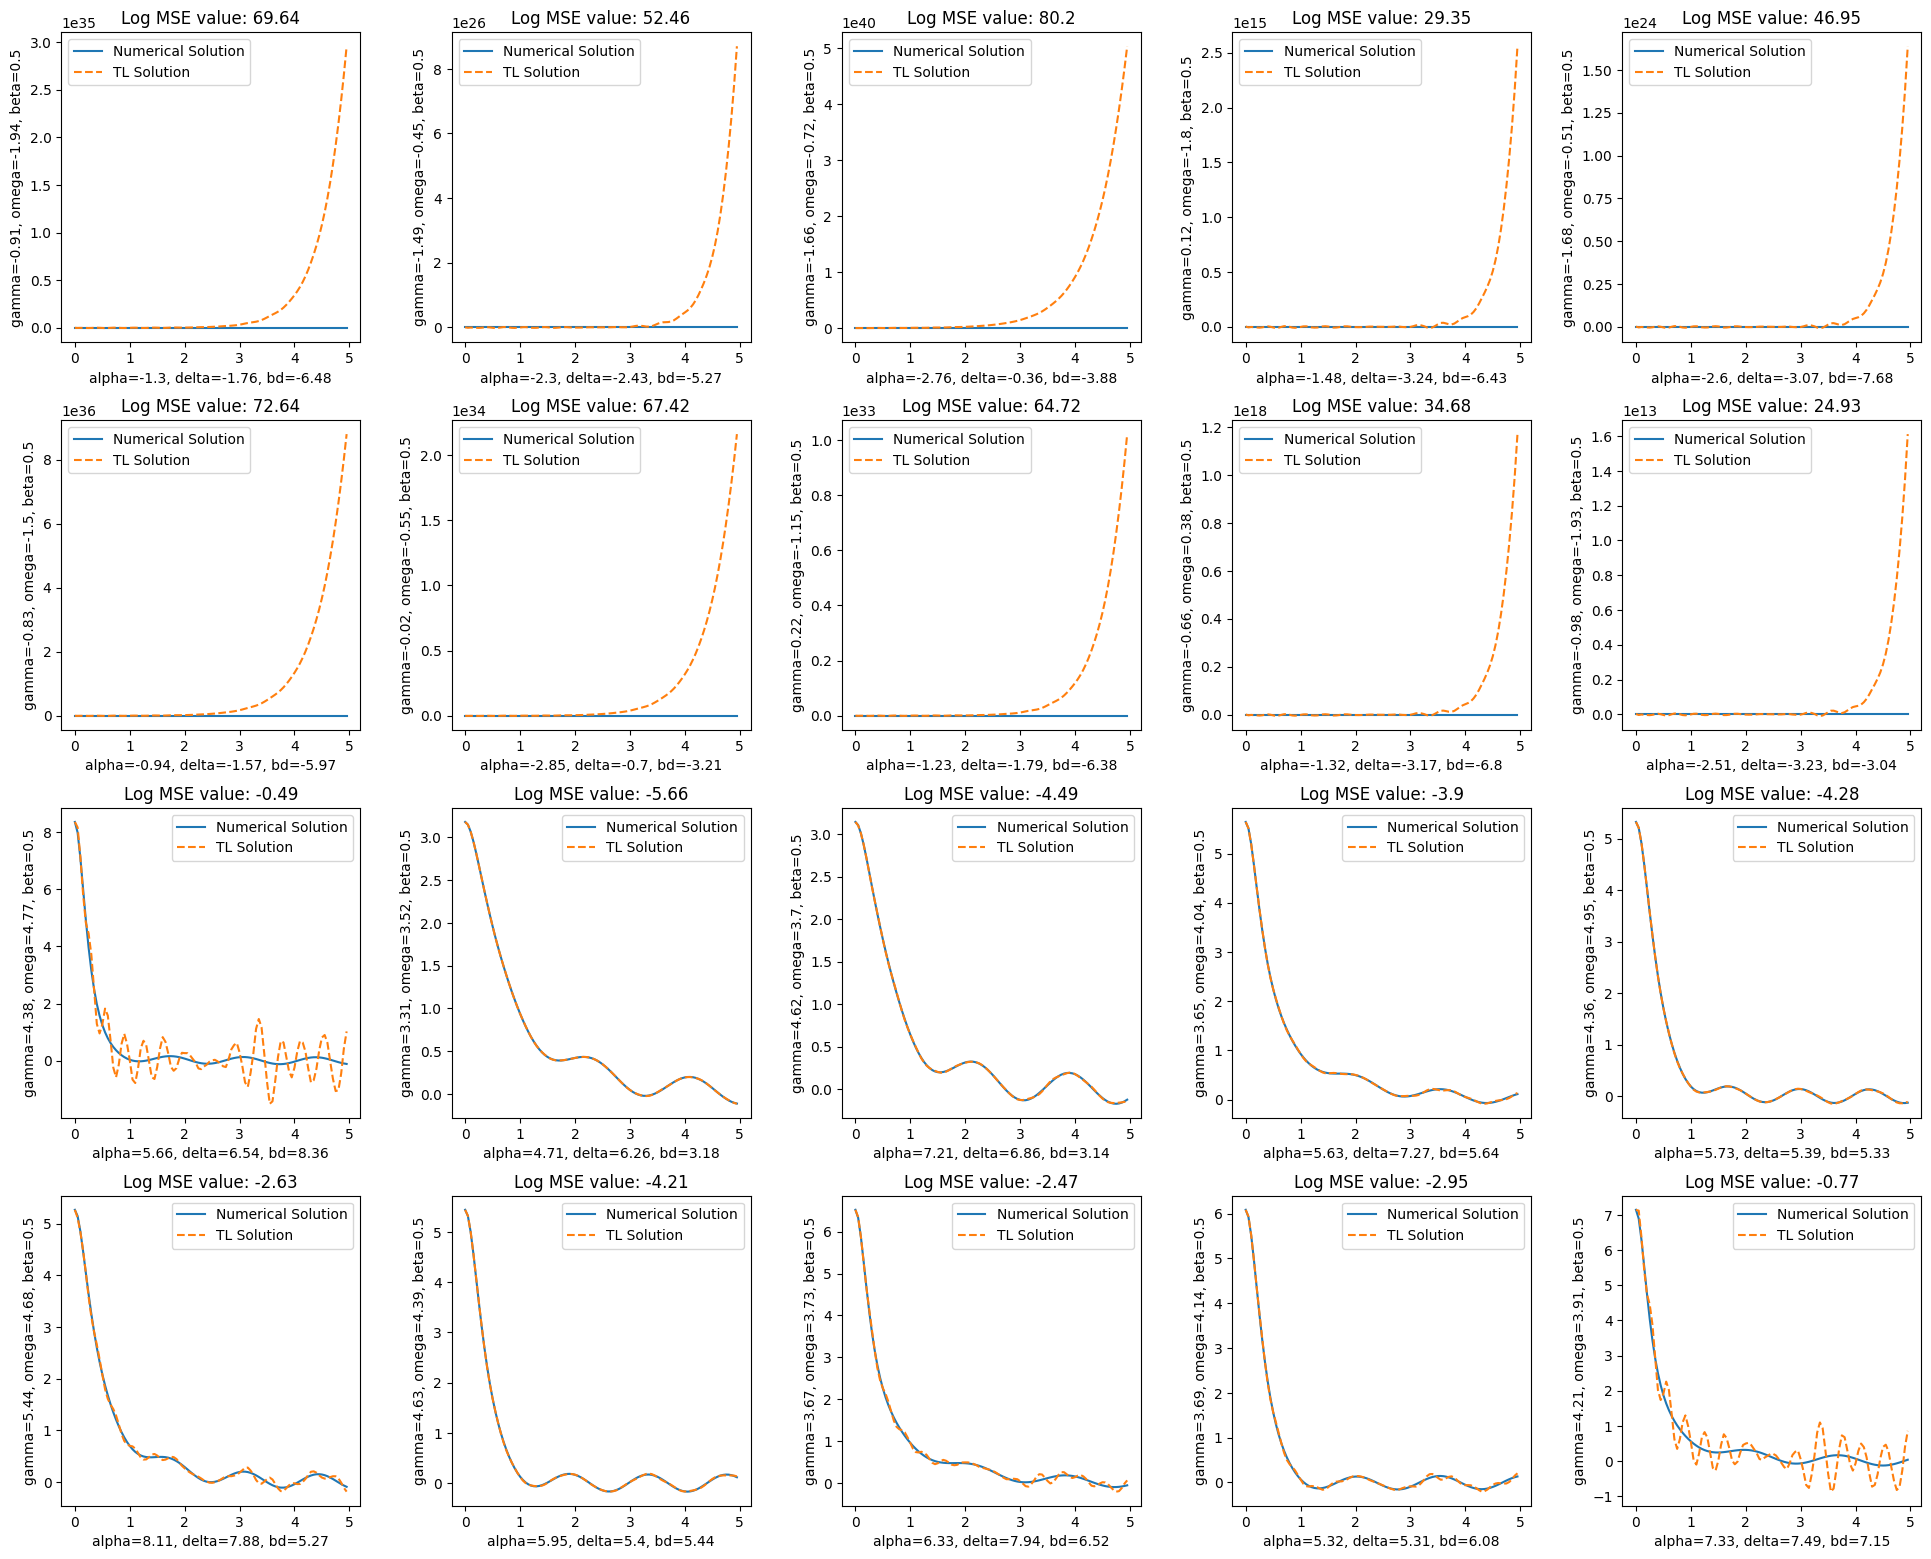

In [ ]:
##plot the solutions
fig, ax = plt.subplots(4, 5, figsize=(20, 16));
fig.tight_layout(pad=3.5)
for i in range(20):
  j = i//5; k = i%5
  ax[j][k].plot(numerical_out[i].t, numerical_out[i].y[0], label='Numerical Solution')
  ax[j][k].plot(X_grid, TL_solutions_out[i], '--', label='TL Solution')
  ##compute the MSE loss value
  loss = MSE_loss(TL_functions_out[i], numerical_out[i])
  ax[j][k].legend();
  ax[j][k].set_title("Log MSE value: " + str(round(np.log10(loss), 2)))
  ax[j][k].set_xlabel("alpha={}, delta={}, bd={}".format(round(out_parameters[0][i][2], 2),
                                                 round(out_parameters[0][i][3], 2),
                                                 round(out_parameters[1][i], 2)))
  ax[j][k].set_ylabel("gamma={}, omega={}, beta={}".format(
      round(out_parameters[0][i][0], 2),
      round(out_parameters[0][i][1], 2),
      0.5
  ))
#plt.savefig(path+'20Random_out_solutions.eps', format='eps')

Now, let's try Duffing Equations with non-zero initial velocities.
As an initial test let's try:

$$
\frac{\partial^2 x}{\partial t^2} + 1.5 \frac{\partial x}{\partial t} + x + 0.5 x^3 = 0.5cos(2t)
$$

with $x_0 = 1$ and $x_0' = 1$

In [ ]:
delta = 1.5; alpha = 1; beta = 0.5; gamma = 0.5; omega = 2
domain = (0, 5.0); X_BOUNDARY = 1; v0 = 1;
##compute numerical solution
solution = solve_duffing(delta, alpha, beta,
                         lambda t: gamma*np.cos(omega*t), [X_BOUNDARY, v0], domain, X_grid)

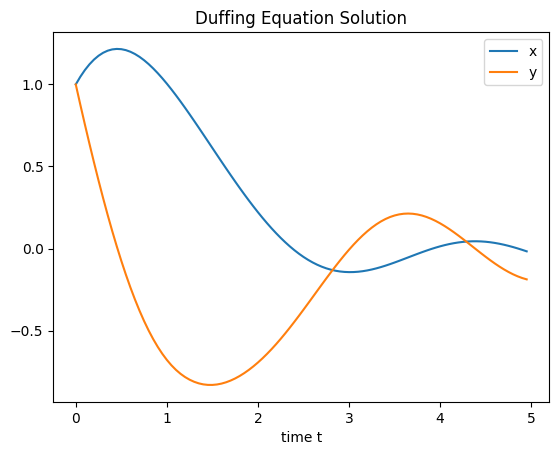

In [ ]:
##plot the numerical solution
plt.plot(solution.t, solution.y[0], label='x');
plt.plot(solution.t, solution.y[1], label='y');
plt.xlabel("time t");
plt.title("Duffing Equation Solution");
plt.legend();

In [ ]:
p = 15
final_function, function_list, W_list = solve_duffing_TL(X_BOUNDARY, beta, p, domain, 200,
                                  alpha, delta, new_params, gamma, omega, v0=v0)

Using uniform initial values of: x0=0.5000076295109483, v0=0.5000076295109483
Solving the 1th linear ode system...
Solving the 2th linear ode system...
Solving the 3th linear ode system...
Solving the 4th linear ode system...
Solving the 5th linear ode system...
Solving the 6th linear ode system...
Solving the 7th linear ode system...
Solving the 8th linear ode system...
Solving the 9th linear ode system...
Solving the 10th linear ode system...
Solving the 11th linear ode system...
Solving the 12th linear ode system...
Solving the 13th linear ode system...
Solving the 14th linear ode system...
Solving the 15th linear ode system...


Plot all p+1 linear system solutions.

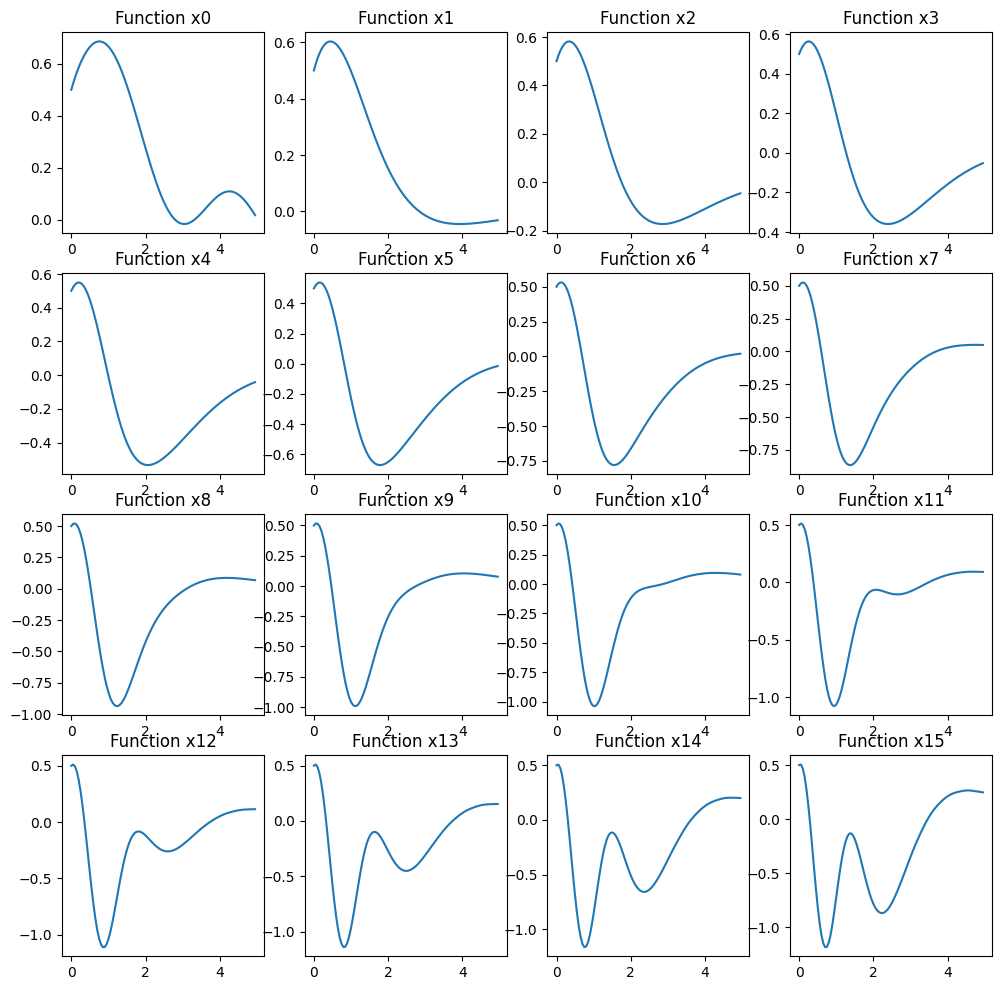

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
for i in range(len(function_list)):
  j = i//4; k = i%4
  ax[j][k].plot(X_grid, function_list[i](X_grid))
  ax[j][k].set_title("Function x{}".format(i))

Plot the TL solution of this Duffing equation together with the numerical solution.

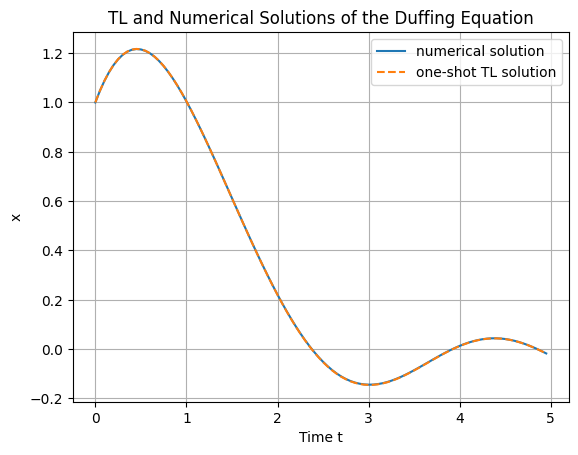

In [ ]:
plt.plot(solution.t, solution.y[0], label='numerical solution');
plt.plot(X_grid, final_function(X_grid), '--', label='one-shot TL solution');
plt.grid();
plt.xlabel("Time t");
plt.ylabel("x");
plt.title("TL and Numerical Solutions of the Duffing Equation");
plt.legend();

See how the solver performs with different p values.

In [ ]:
P = 15
Final_List = []; Function_List_list = []; weights_list = []
for p in range(2, P+1):
  print("p = {}".format(p))
  ff, fl, w = solve_duffing_TL(X_BOUNDARY, beta, p, domain, 200,
                                  alpha, delta, new_params, gamma, omega, v0=v0)
  Final_List.append(ff)
  Function_List_list.append(fl)
  weights_list.append(w)
  print()

p = 2
Using uniform initial values of: x0=0.5714285714285714, v0=0.5714285714285714
Solving the 1th linear ode system...
Solving the 2th linear ode system...

p = 3
Using uniform initial values of: x0=0.5333333333333333, v0=0.5333333333333333
Solving the 1th linear ode system...
Solving the 2th linear ode system...
Solving the 3th linear ode system...

p = 4
Using uniform initial values of: x0=0.5161290322580645, v0=0.5161290322580645
Solving the 1th linear ode system...
Solving the 2th linear ode system...
Solving the 3th linear ode system...
Solving the 4th linear ode system...

p = 5
Using uniform initial values of: x0=0.5079365079365079, v0=0.5079365079365079
Solving the 1th linear ode system...
Solving the 2th linear ode system...
Solving the 3th linear ode system...
Solving the 4th linear ode system...
Solving the 5th linear ode system...

p = 6
Using uniform initial values of: x0=0.5039370078740157, v0=0.5039370078740157
Solving the 1th linear ode system...
Solving the 2th linea

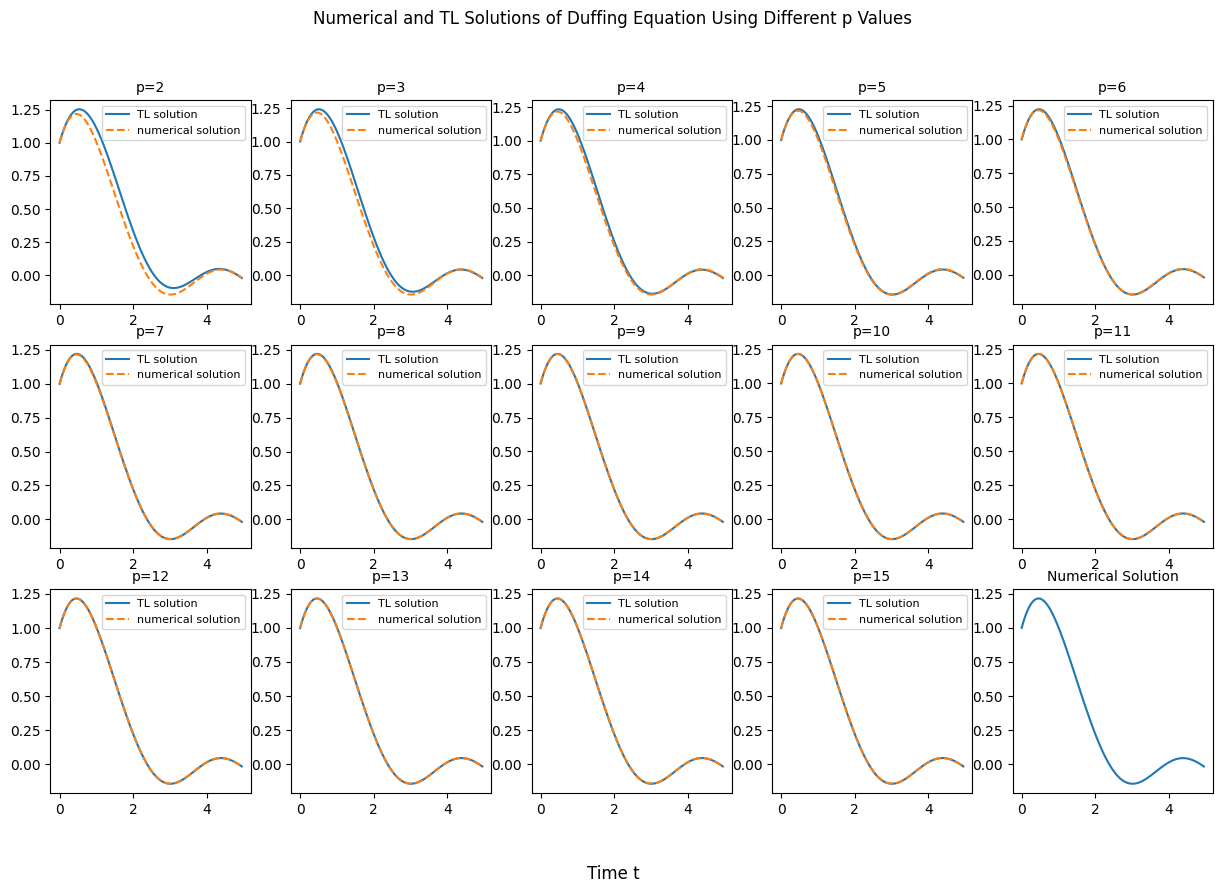

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(15, 9))
for i in range(len(Final_List)):
  j = i//5; k = i%5
  ax[j][k].plot(X_grid, Final_List[i](X_grid).flatten(), label='TL solution')
  ax[j][k].plot(solution.t, solution.y[0], '--', label='numerical solution')
  ax[j][k].legend(fontsize=8);
  ax[j][k].set_title("p={}".format(i+2), fontsize=10)
ax[2][4].plot(solution.t, solution.y[0]);
ax[2][4].set_title("Numerical Solution", fontsize=10);
fig.supxlabel("Time t");
fig.suptitle("Numerical and TL Solutions of Duffing Equation Using Different p Values");
#plt.savefig(path+'Solving_duffing_using_different_p_nonzero_v0.eps', format='eps')

Plot the MSE error vs. the p values.

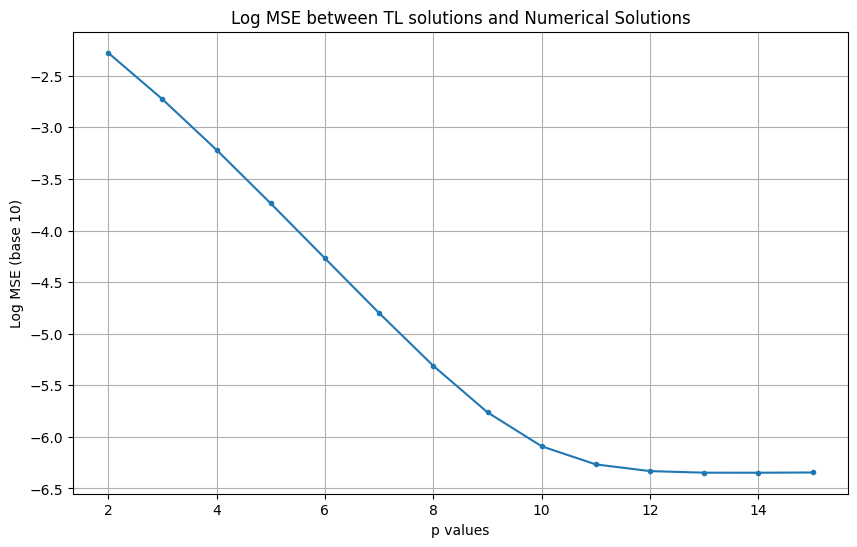

In [ ]:
##compute the MSE loss for all p values and plot them
mse_losts = []
for f in Final_List:
  mse_losts.append(MSE_loss(f, solution))

plt.figure(figsize=(10, 6));
plt.plot(range(2, len(Final_List)+2), np.log10(mse_losts), '.-');
plt.grid();
plt.title("Log MSE between TL solutions and Numerical Solutions");
plt.xlabel("p values");
plt.ylabel("Log MSE (base 10)");
#plt.savefig(path+'logMSE_vs_p_nonzero_v0.eps', format='eps')

Try 20 random in-distribution Duffing Equations with non-zero initial velocities. Fix beta = 0.5.

In [ ]:
##generate 20 random set of new parameters for Duffing equation

gamma_bounds = (0.5, 3)
w_bounds = (0.5, 3)
alpha_bounds = (0.5, 4.5)
delta_bounds = (0.5, 4.5)
boundary_bounds = (-3, 3)
v0_bounds = (-1, 1)

Duffing_parameters = generate_parameters(20, gb = gamma_bounds,
                        wb = w_bounds, ab = alpha_bounds, db = delta_bounds,
                        bounds=boundary_bounds, vb=v0_bounds, seed=1)

In [ ]:
##solve these 20 Duffing equations numerically and using TL
nume_duff_solution = []
TL_duff_functions = []
TL_duff_solution = []
for i in range(20):
  print(i)
  delta = Duffing_parameters[0][i][3]
  alpha = Duffing_parameters[0][i][2]
  bd = Duffing_parameters[1][i]
  v0 = Duffing_parameters[2][i]
  gamma = Duffing_parameters[0][i][0]
  omega = Duffing_parameters[0][i][1]
  #numerical solutions
  solu = solve_duffing(delta, alpha, 0.5,
                       lambda t: gamma*np.cos(omega*t),
                        [bd, v0], domain, X_grid)
  nume_duff_solution.append(solu)
  #TL solutions
  p=12
  ff, _, _ = solve_duffing_TL(bd, 0.5, p, domain, 200, alpha, delta,
                              new_params, gamma, omega, v0=v0, verbose=False)
  TL_duff_functions.append(ff)
  TL_duff_solution.append(ff(X_grid.flatten()))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


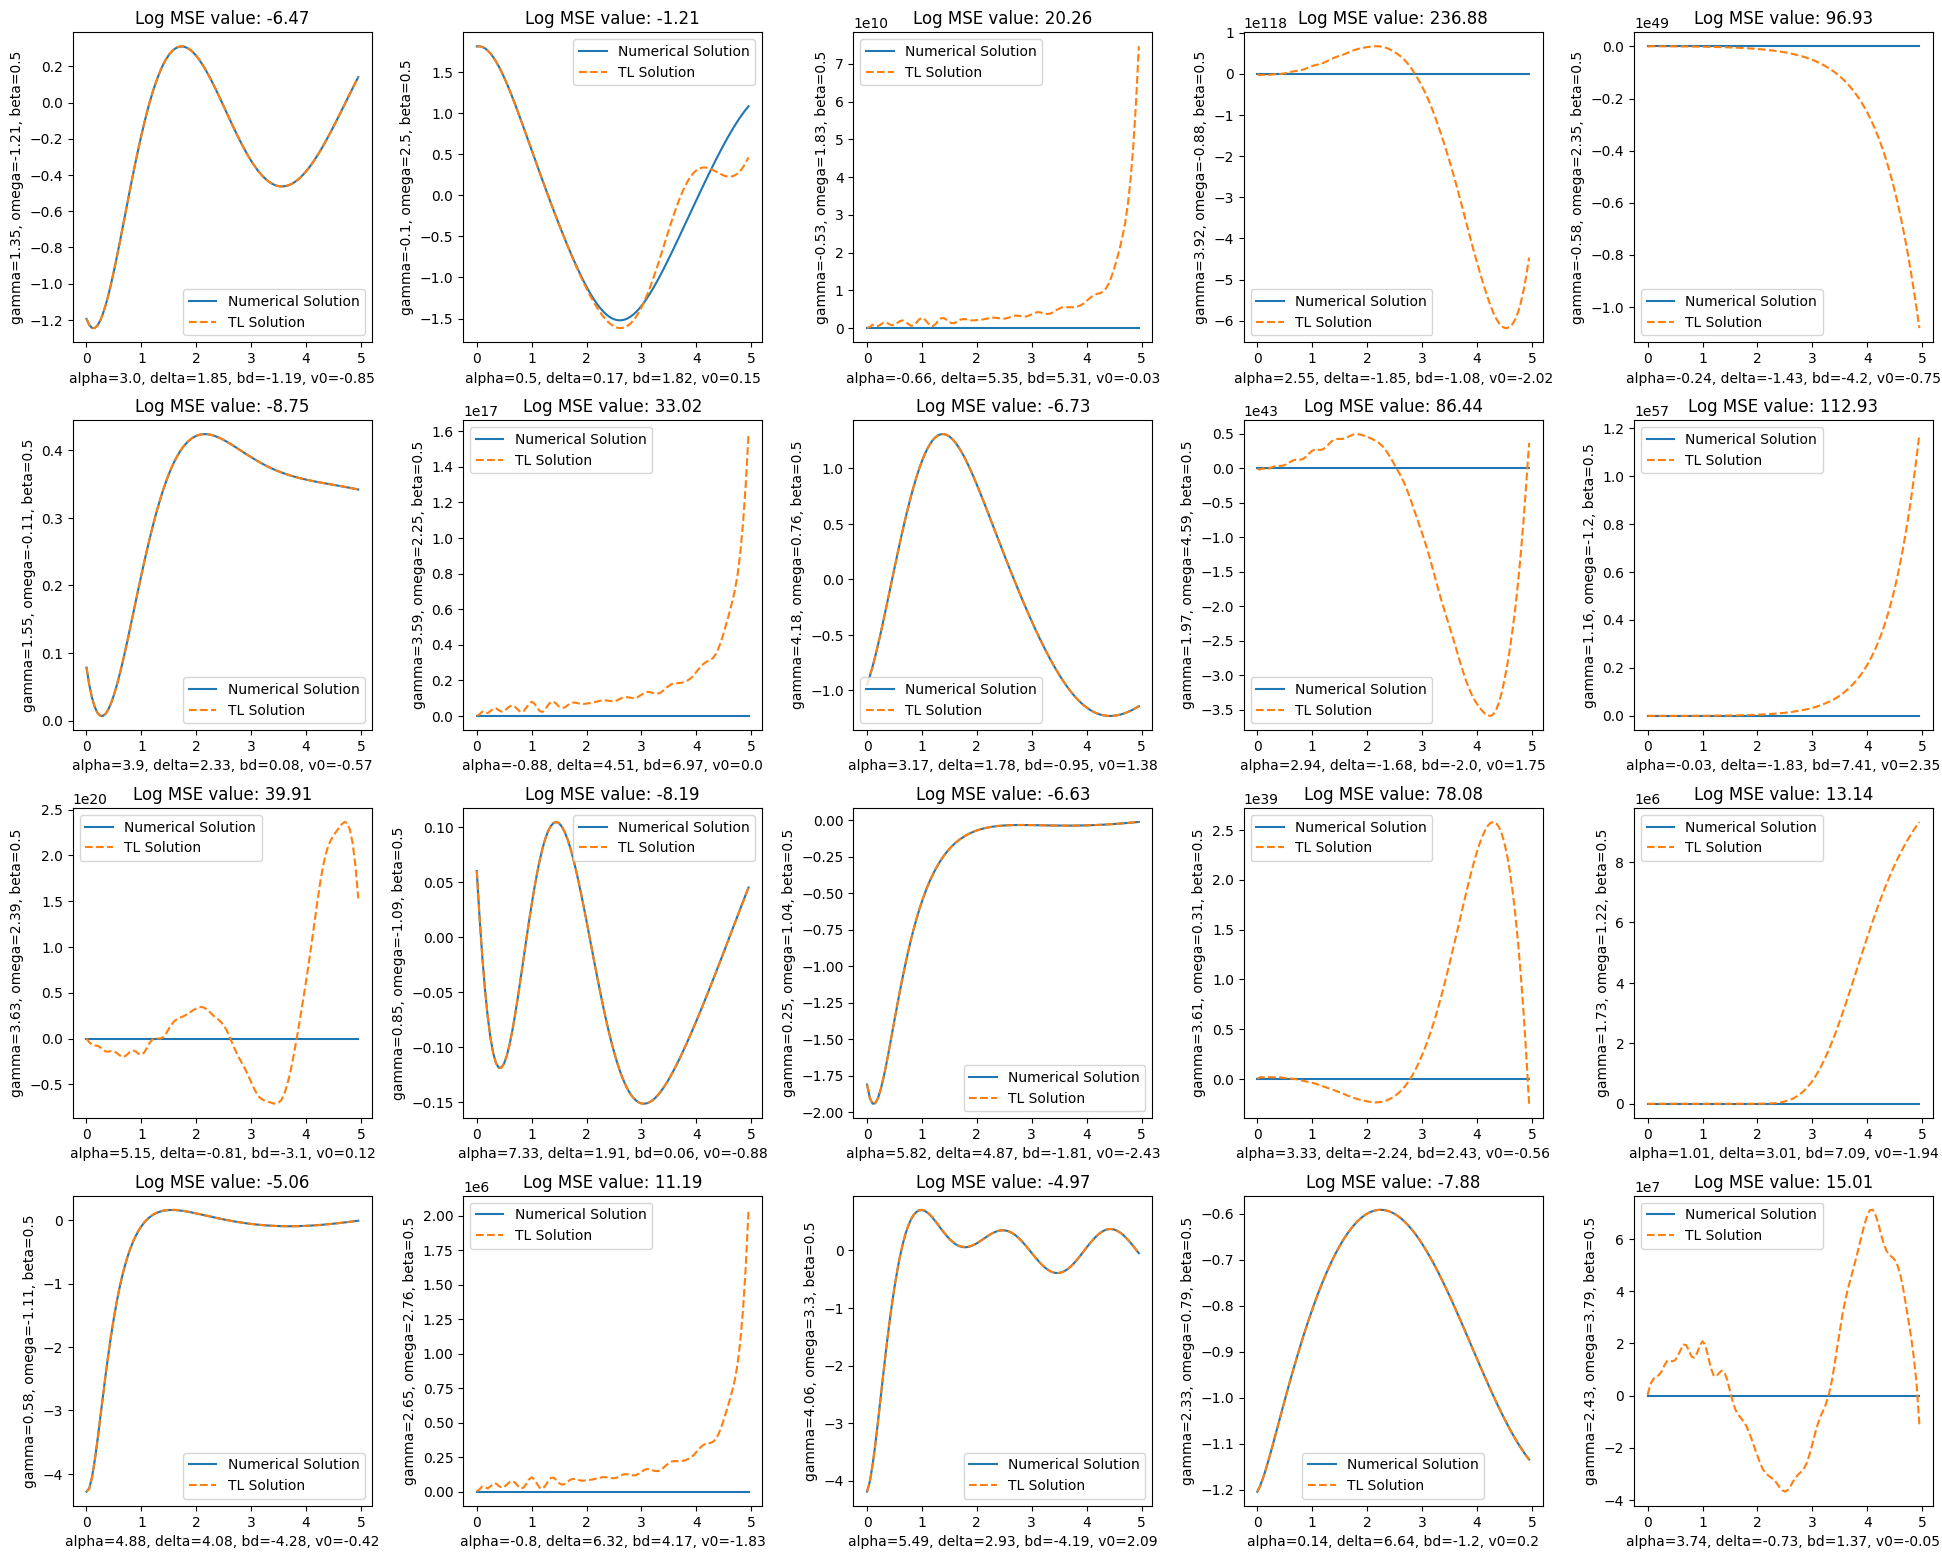

In [ ]:
##plot the solutions
fig, ax = plt.subplots(4, 5, figsize=(20, 16));
fig.tight_layout(pad=3.5)
for i in range(20):
  j = i//5; k = i%5
  ax[j][k].plot(nume_duff_solution[i].t, nume_duff_solution[i].y[0], label='Numerical Solution')
  ax[j][k].plot(X_grid, TL_duff_solution[i], '--', label='TL Solution')
  ##compute the MSE loss value
  loss = MSE_loss(TL_duff_functions[i], nume_duff_solution[i])
  ax[j][k].legend();
  ax[j][k].set_title("Log MSE value: " + str(round(np.log10(loss), 2)))
  ax[j][k].set_xlabel("alpha={}, delta={}, bd={}, v0={}".format(round(Duffing_parameters[0][i][2], 2),
                                                 round(Duffing_parameters[0][i][3], 2),
                                                 round(Duffing_parameters[1][i], 2),
                                                 round(Duffing_parameters[2][i], 2)))
  ax[j][k].set_ylabel("gamma={}, omega={}, beta={}".format(
      round(Duffing_parameters[0][i][0], 2),
      round(Duffing_parameters[0][i][1], 2),
      0.5
  ))
#plt.savefig(path+'20_indistribution_duffing_solutions_nonzero_v0.eps', format='eps')

### Out-of-distribution performances
Try 20 random out-of-distribution Duffing Equations. The parameters are generated using a much wider range.


In [ ]:
##generate 20 random set of new parameters for Duffing equation
gamma_bounds = (-1.375, 4.875)
w_bounds = (-1.375, 4.875)
alpha_bounds = (-2.5, 7.5)
delta_bounds = (-2.5, 7.5)
boundary_bounds = (-7.5, 7.5)
v0_bounds = (-2.5, 2.5)

Duffing_parameters = generate_parameters(20, gb = gamma_bounds,
                        wb = w_bounds, ab = alpha_bounds, db = delta_bounds,
                        bounds=boundary_bounds, vb=v0_bounds, seed=2)

In [ ]:
##solve these 20 Duffing equations numerically and using TL
nume_duff_solution = []
TL_duff_functions = []
TL_duff_solution = []
for i in range(20):
  print(i)
  delta = Duffing_parameters[0][i][3]
  alpha = Duffing_parameters[0][i][2]
  bd = Duffing_parameters[1][i]
  v0 = Duffing_parameters[2][i]
  gamma = Duffing_parameters[0][i][0]
  omega = Duffing_parameters[0][i][1]
  #numerical solutions
  solu = solve_duffing(delta, alpha, 0.5,
                       lambda t: gamma*np.cos(omega*t),
                        [bd, v0], domain, X_grid)
  nume_duff_solution.append(solu)
  #TL solutions
  p=12
  ff, _, _ = solve_duffing_TL(bd, 0.5, p, domain, 200, alpha, delta,
                              new_params, gamma, omega, v0=v0, verbose=False)
  TL_duff_functions.append(ff)
  TL_duff_solution.append(ff(X_grid.flatten()))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


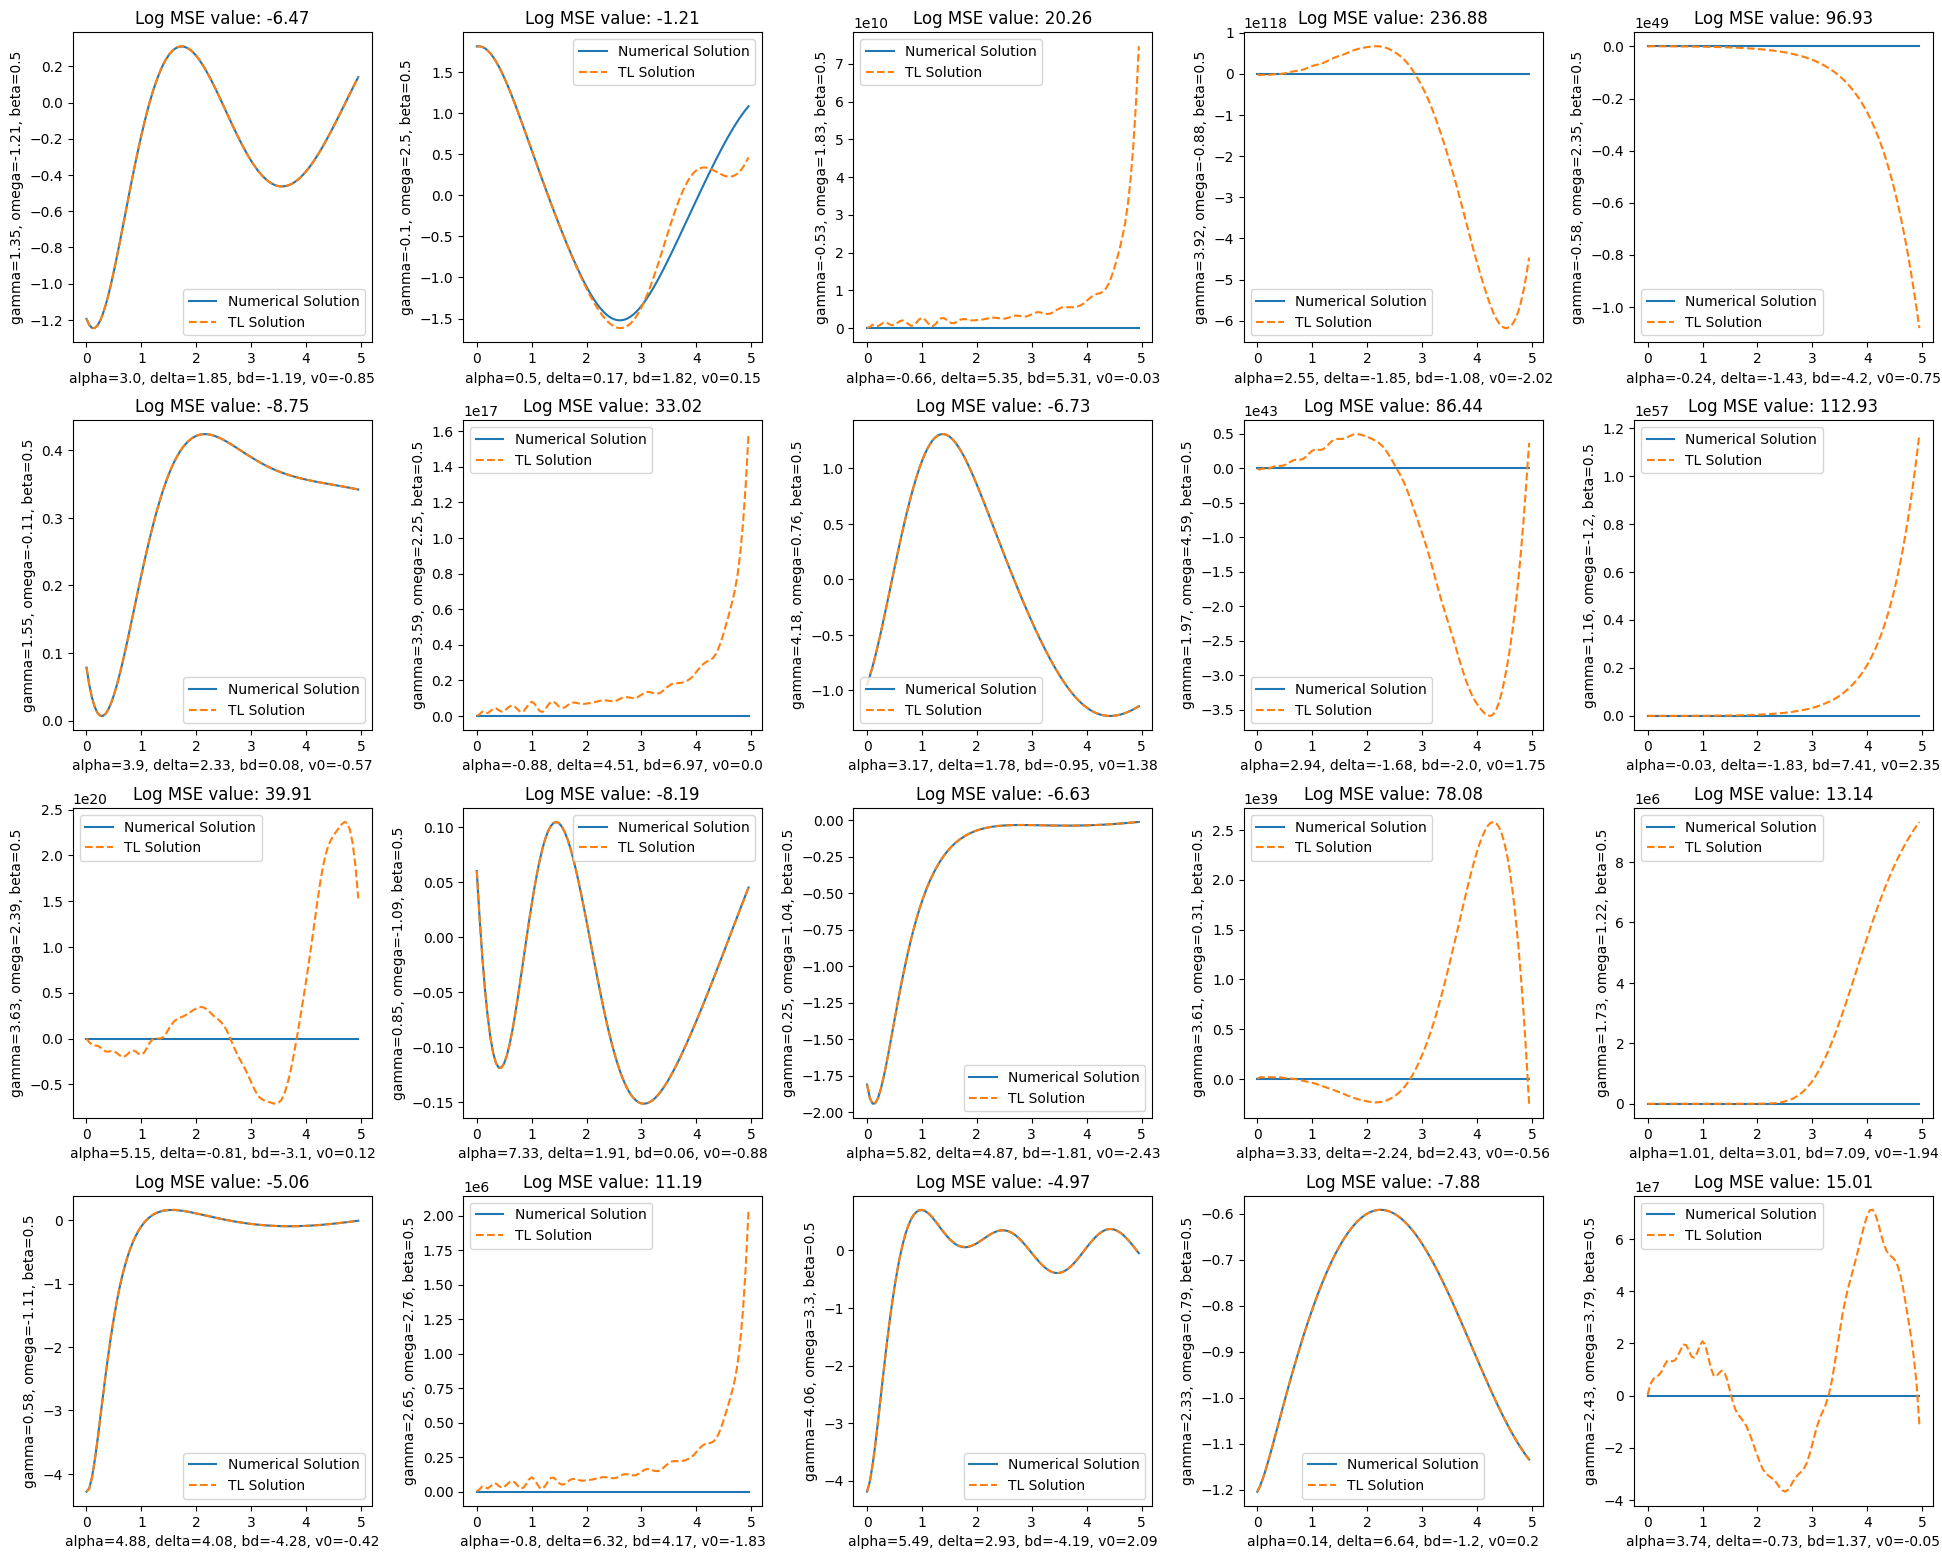

In [ ]:
##plot the solutions
fig, ax = plt.subplots(4, 5, figsize=(20, 16));
fig.tight_layout(pad=3.5)
for i in range(20):
  j = i//5; k = i%5
  ax[j][k].plot(nume_duff_solution[i].t, nume_duff_solution[i].y[0], label='Numerical Solution')
  ax[j][k].plot(X_grid, TL_duff_solution[i], '--', label='TL Solution')
  ##compute the MSE loss value
  loss = MSE_loss(TL_duff_functions[i], nume_duff_solution[i])
  ax[j][k].legend();
  ax[j][k].set_title("Log MSE value: " + str(round(np.log10(loss), 2)))
  ax[j][k].set_xlabel("alpha={}, delta={}, bd={}, v0={}".format(round(Duffing_parameters[0][i][2], 2),
                                                 round(Duffing_parameters[0][i][3], 2),
                                                 round(Duffing_parameters[1][i], 2),
                                                 round(Duffing_parameters[2][i], 2)))
  ax[j][k].set_ylabel("gamma={}, omega={}, beta={}".format(
      round(Duffing_parameters[0][i][0], 2),
      round(Duffing_parameters[0][i][1], 2),
      0.5
  ))
#plt.savefig(path+'20_outdistribution_duffing_solutions_nonzero_v0.eps', format='eps')

The result shows that the perturbation method solver with TL solves the equation very well with the right out of distribution parameters (the second range shown before). But it fails to solve the equation with left out of distribution parameters (first range shown before).


Then the next step is to train the PINN using more diverse forcing functions.

First, we need to set out the set of forcing functions we want the network to learn. We consider trigonometric functions raised to higher orders.

Consider the following function format:

$$
f(t) = (a_1cos(w_1 t) + a_2cos(w_2t) + a_3cos(w_3t))^k
$$

For the first try, I will use 20 heads in the PINNs. with the following number of forcing functions:

1. 7 functions of format $\gamma cos(\omega t)$
2. 7 functions of format $(a_1cos(w_1t) + a_2cos(w_2t) + a_3cos(w_3t))^k$, k from 1 to 7
3. 6 functions of format $(a_1cos(w_1t) + a_2cos(w_2t) + a_3cos(w_3t))^{8}$

In [ ]:
##generate 20 random such functions
gamma_bounds = (0.5, 3)
w_bounds = (0.5, 3)
np.random.seed(0)
function_list = []

def decorator1(r, w):
  def f(t):
    return r*np.cos(w*t)
  return f

def decorator2(a1, a2, a3, w1, w2, w3, k):
  def f(t):
    return (a1*np.cos(w1*t)+ a2*np.cos(w2*t) + a3*np.cos(w3*t))**k
  return f

a_list = []; w_list = []

for i in range(7):
  r = np.random.uniform(*gamma_bounds)
  w = np.random.uniform(*w_bounds)
  function_list.append(decorator1(r, w))
for i in range(7):
  [a1, a2, a3] = np.random.uniform(0.2, 0.6, 3)
  [w1, w2, w3] = np.random.uniform(1.5, 2.5, 3)
  a_list.append([a1, a2, a3]); w_list.append([w1, w2, w3])
  function_list.append(decorator2(a1, a2, a3, w1, w2, w3, i+1))
for i in range(6):
  [a1, a2, a3] = np.random.uniform(0.2, 0.6, 3)
  [w1, w2, w3] = np.random.uniform(1.5, 2.5, 3)
  a_list.append([a1, a2, a3])
  w_list.append([w1, w2, w3])
  function_list.append(decorator2(a1, a2, a3, w1, w2, w3, 8))

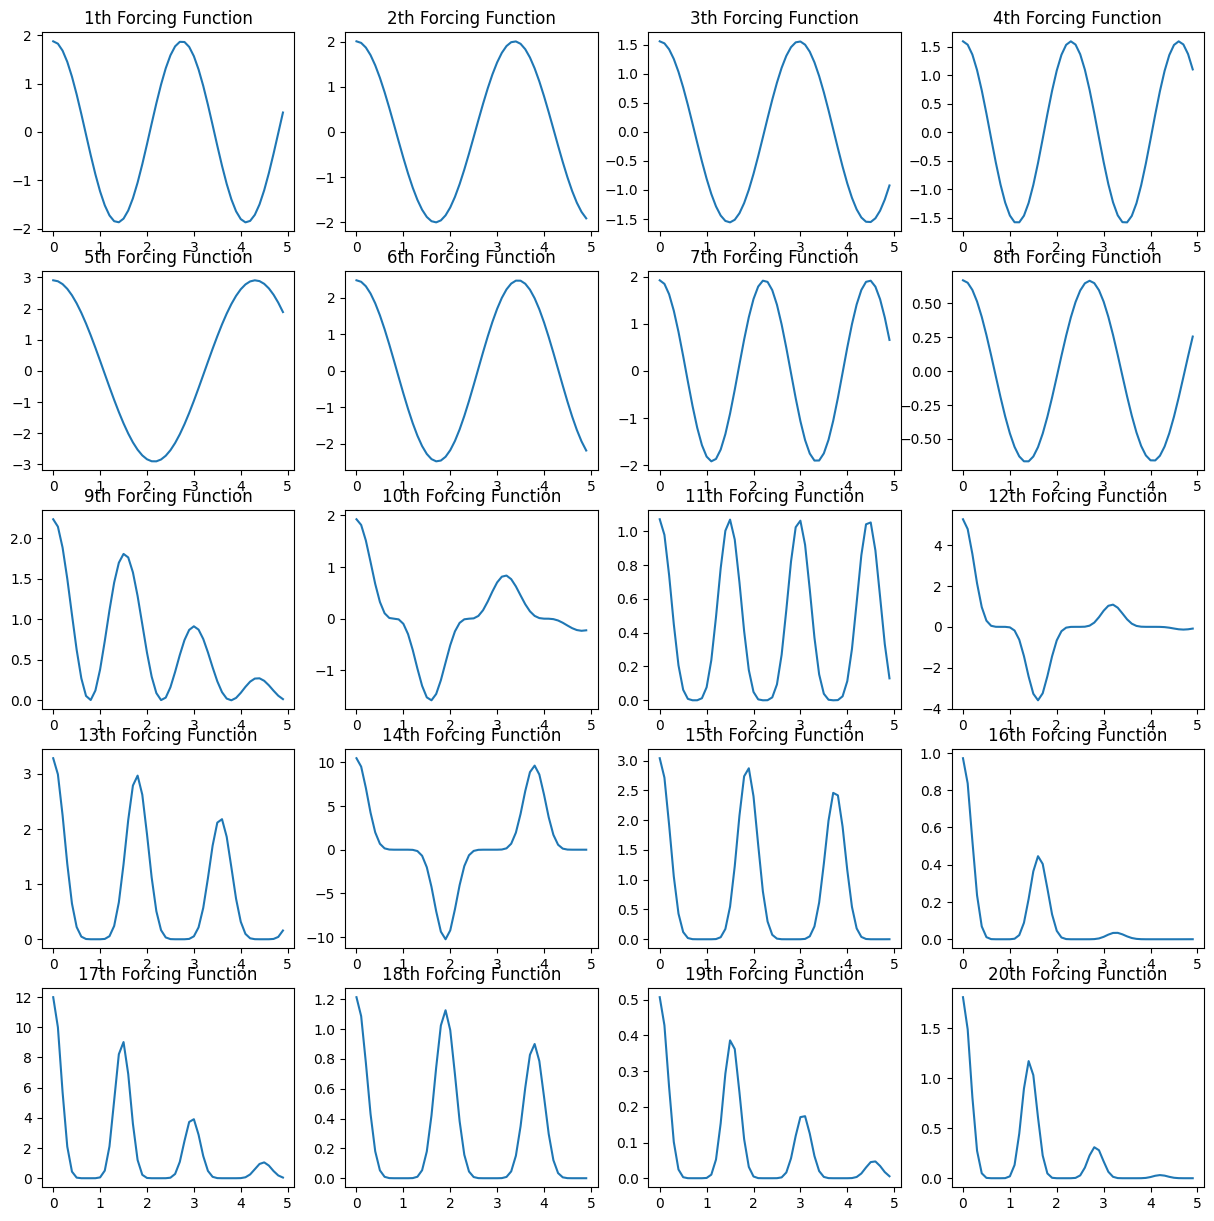

In [ ]:
##plot these forcing functions
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.1))
fig, ax = plt.subplots(5, 4, figsize=(15, 15))
for i in range(len(function_list)):
  j = i//4; k = i%4
  ax[j][k].plot(X_grid, function_list[i](X_grid));
  ax[j][k].set_title("{}th Forcing Function".format(i+1))

In [ ]:
##retrain the model using 20 heads
def Function_Decorator(f):
  def F(t):
    return torch.stack([torch.zeros_like(t), f(t)]).T
  return F
Function_list = [Function_Decorator(f) for f in function_list]

In [ ]:
##construct a model of 10 heads
k=20
model = Multihead(k=k)
fmodel, params = make_functional(model)

In [ ]:
parameter_set, F_BOUNDARIES = generate_parameters(k, seed=12)
A_matrices = torch.zeros(k, 2, 2)
for i in range(k):
  A_matrices[i] = torch.Tensor([[0.0, -1.0], [parameter_set[i][2], parameter_set[i][3]]])

In [ ]:
#define optimization configuration
batch_size = 100 ##number of colocation points sampled in each iteration
num_iter = 4000 #maximum number of iterations
learning_rate = 3e-4
domain = (0, 5.0) #logistic equation domain

#choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

In [ ]:
Alpha=1
new_params, loss_trace, colocation_trace, BC_trace = train_model(num_iter, params,
                          batch_size, domain, A_matrices, Function_list,
                                    optimizer, alpha=Alpha, display_every=100)

Iteration 99 with loss 0.9270027875900269, colocation: 0.7994101643562317, BC: 0.12759265303611755
Iteration 199 with loss 0.5767393112182617, colocation: 0.5724306702613831, BC: 0.004308611620217562
Iteration 299 with loss 0.3370104134082794, colocation: 0.3353816866874695, BC: 0.0016287307953462005
Iteration 399 with loss 0.19384917616844177, colocation: 0.19303776323795319, BC: 0.000811419275123626
Iteration 499 with loss 0.11839888989925385, colocation: 0.11807683110237122, BC: 0.00032205734169110656
Iteration 599 with loss 0.05549103766679764, colocation: 0.05533045530319214, BC: 0.00016058344044722617
Iteration 699 with loss 0.029684219509363174, colocation: 0.02955992892384529, BC: 0.00012429118214640766
Iteration 799 with loss 0.020975686609745026, colocation: 0.020896540954709053, BC: 7.914547313703224e-05
Iteration 899 with loss 0.014714055694639683, colocation: 0.014610589481890202, BC: 0.00010346648195991293
Iteration 999 with loss 0.011234750971198082, colocation: 0.011179

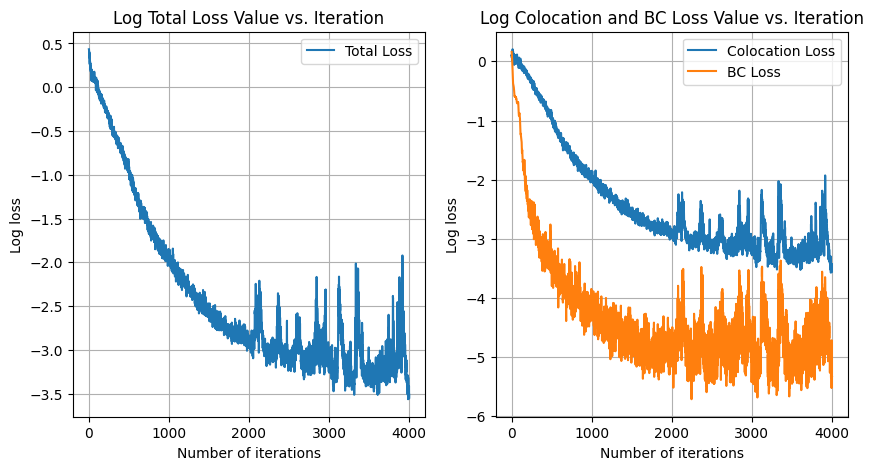

In [ ]:
##plot the loss value
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, num_iter+1), np.log10(loss_trace), label='Total Loss');
ax[1].plot(range(1, num_iter+1), np.log10(colocation_trace), label='Colocation Loss');
ax[1].plot(range(1, num_iter+1), np.log10(BC_trace), label="BC Loss");

ax[0].set_xlabel("Number of iterations");
ax[0].set_ylabel("Log loss");
ax[0].set_title("Log Total Loss Value vs. Iteration");
ax[0].grid();
ax[0].legend();
ax[1].set_xlabel("Number of iterations");
ax[1].set_ylabel("Log loss");
ax[1].set_title("Log Colocation and BC Loss Value vs. Iteration");
ax[1].grid();
ax[1].legend();

In [ ]:
#get the network solution
X_grid = torch.FloatTensor(np.arange(domain[0], domain[1], 0.05))
Y_NN = f_multihead_vmap(X_grid, new_params) #shape (100, 20, 2)
Y_NN = Y_NN.transpose(0, 1)

In [ ]:
##get numerical solutions
#define the RHS function decorator
def RHS_decorator(f, alpha, delta):
  def func(t, y):
    y = np.array(y)
    A_mat = np.array([[0, -1], [alpha, delta]])
    return -A_mat@y + np.array([0, f(t)])
  return func

t_eval = np.arange(domain[0], domain[1], 0.05)
##construct a list of RHS functions
RHS_functions = [RHS_decorator(function_list[i], parameter_set[i][2], parameter_set[i][3]) for i in range(k)]

numerical_result = [solve_ivp(RHS_functions[i], domain,
                    np.array([F_BOUNDARIES[i], 0]), t_eval=t_eval) for i in range(k)]

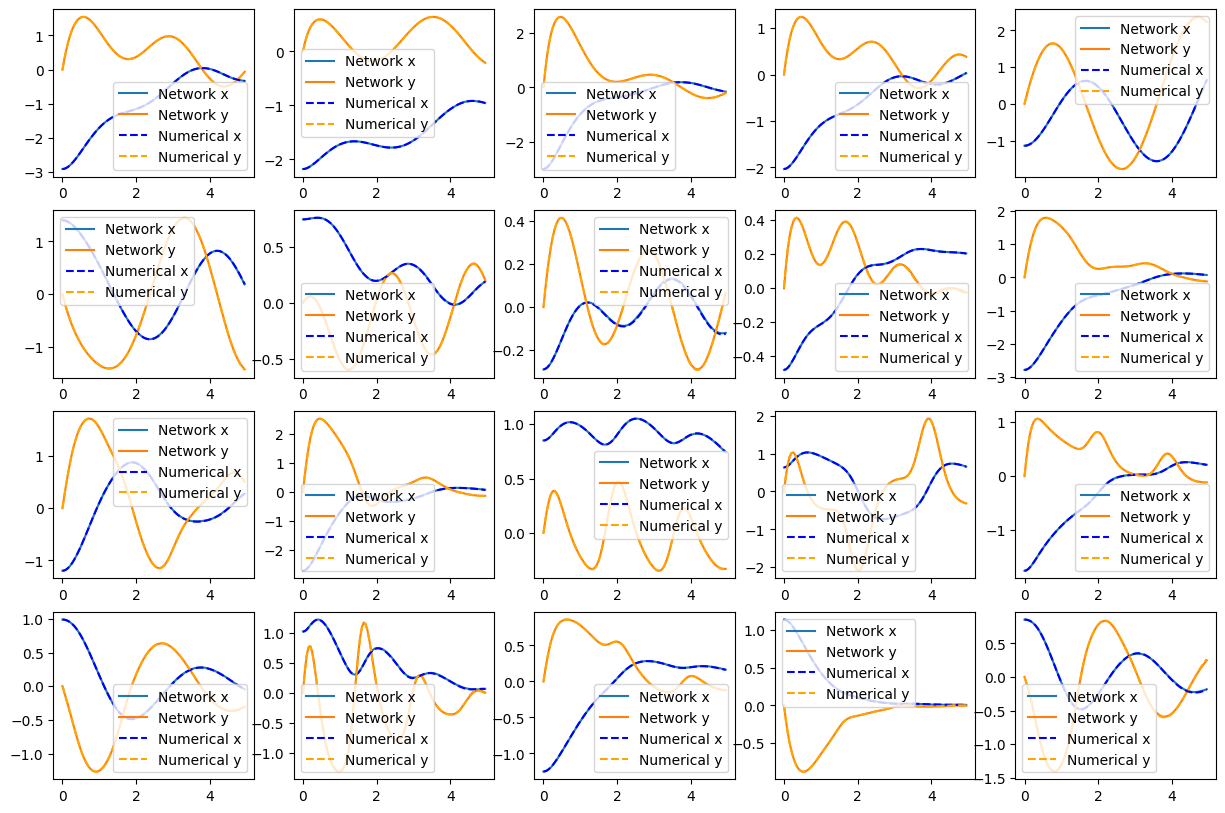

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(15, 10));
for i in range(k):
  j = i//5; l = i%5
  ax[j][l].plot(X_grid, Y_NN[i][:,0].detach().numpy(), label="Network x");
  ax[j][l].plot(X_grid, Y_NN[i][:,1].detach().numpy(), label='Network y');
  ax[j][l].plot(t_eval, numerical_result[i].y[0], '--', c='blue',label='Numerical x');
  ax[j][l].plot(t_eval, numerical_result[i].y[1], '--', c='orange',label='Numerical y');
  ax[j][l].legend();

We can see that 20 head PINN is trained very well to almost solve the 20 system with complex forcing functions exactly.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##save the parameters for future use
import pickle
file = open('/content/drive/MyDrive/PINN/PINN_program/new_params_20heads.obj', 'wb')
pickle.dump(new_params, file)
file.close()

In [ ]:
##reload the parameters if necessary
import pickle
file = open('/content/drive/MyDrive/PINN/PINN_program/new_params_20heads.obj', 'rb')
new_params = pickle.load(file)

Test the one-shot TL on the 20-head PINN to Solve Duffing Equation

In [ ]:
p = 15
final_function, function_list, W_list = solve_duffing_TL(X_BOUNDARY, beta, p, domain, 200,
                                  alpha, delta, new_params, gamma, omega)

Using uniform initial values of: 0.5000076295109483
Solving the 1th linear ode system...
Solving the 2th linear ode system...
Solving the 3th linear ode system...
Solving the 4th linear ode system...
Solving the 5th linear ode system...
Solving the 6th linear ode system...
Solving the 7th linear ode system...
Solving the 8th linear ode system...
Solving the 9th linear ode system...
Solving the 10th linear ode system...
Solving the 11th linear ode system...
Solving the 12th linear ode system...
Solving the 13th linear ode system...
Solving the 14th linear ode system...
Solving the 15th linear ode system...


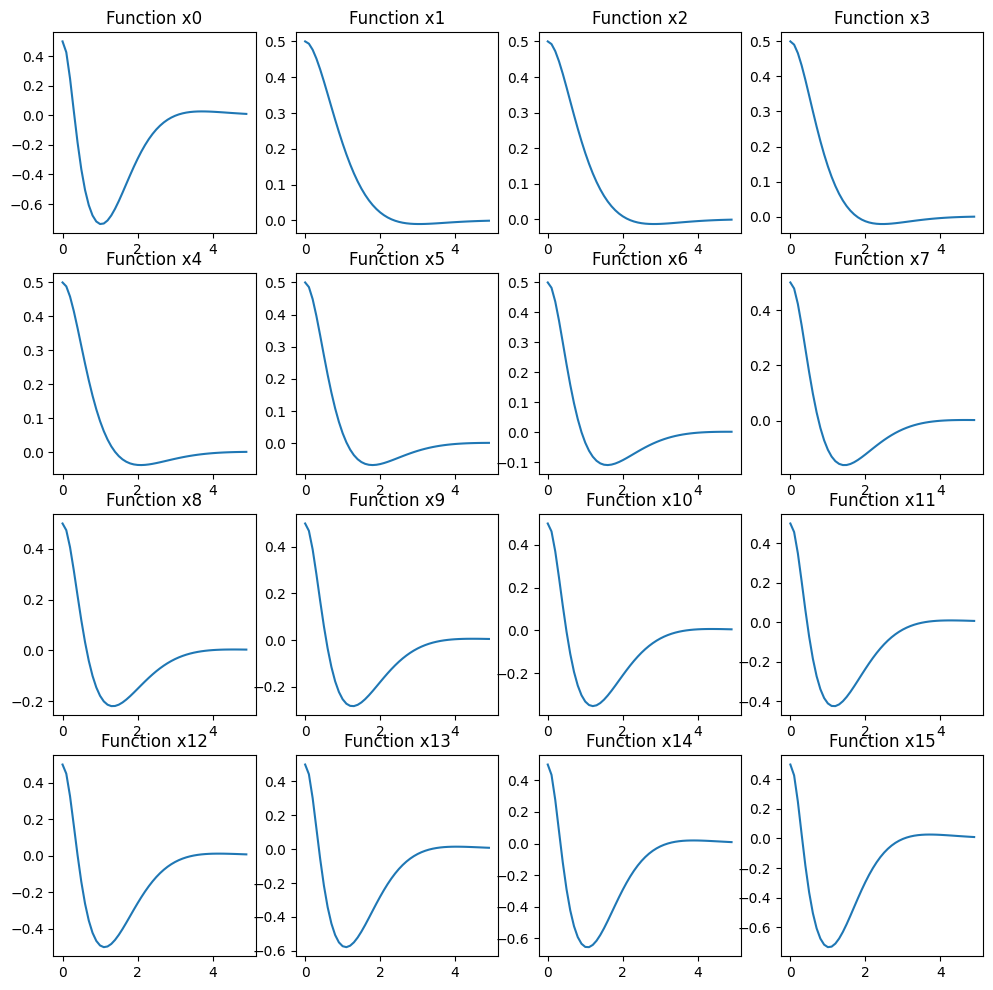

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
for i in range(len(function_list)):
  j = i//4; k = i%4
  ax[j][k].plot(X_grid, function_list[i](X_grid))
  ax[j][k].set_title("Function x{}".format(i))

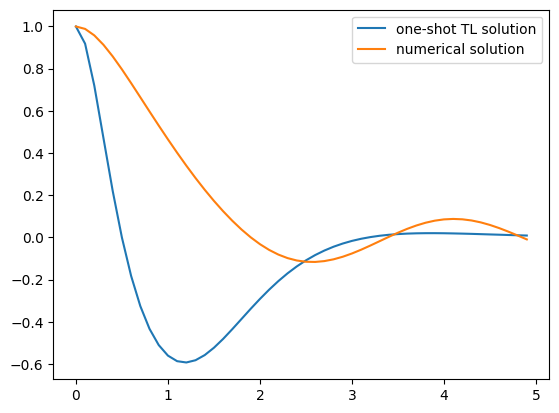

In [ ]:
plt.plot(X_grid, final_function(X_grid), label='one-shot TL solution');
plt.plot(solution.t, solution.y[0], label='numerical solution');
plt.legend();

We can see that using 20 heads and using more diverse and more complex forcing functions does not help.... Something else went wrong.